In [1]:
# ===================================================================
#      0. Import all the desired libraries
# ===================================================================

import numpy as np
import torch
import copy
import time
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import matplotlib.pyplot as plt
import healpy as hp


In [2]:
# ===================================================================
#      1. REUSABLE FUNCTIONS (Data preprocessing and evaluation logic)
# ===================================================================

def transform_event_features(event_sets, angular_feature_indices):
    transformed_event_sets = []
    if not angular_feature_indices: return [events.copy() for events in event_sets]
    for events in event_sets: # Removed tqdm for cleaner integration
        if events.shape[0] == 0:
            transformed_event_sets.append(events)
            continue
        non_angular_indices = [i for i in range(events.shape[1]) if i not in angular_feature_indices]
        new_feature_parts = [events[:, non_angular_indices]]
        for idx in angular_feature_indices:
            angles_rad = np.deg2rad(events[:, idx])
            new_feature_parts.extend([np.cos(angles_rad)[:, np.newaxis], np.sin(angles_rad)[:, np.newaxis]])
        transformed_events = np.concatenate(new_feature_parts, axis=1)
        transformed_event_sets.append(transformed_events)
    return transformed_event_sets

def convert_to_cartesian(coords_deg):
    lon_deg, lat_deg = coords_deg[:, 0], coords_deg[:, 1]
    lon_rad, lat_rad = np.deg2rad(lon_deg), np.deg2rad(lat_deg)
    x, y, z = np.cos(lon_rad) * np.cos(lat_rad), np.sin(lon_rad) * np.cos(lat_rad), np.sin(lat_rad)
    return np.stack([x, y, z], axis=1)

def convert_cartesian_to_lon_lat(cartesian_coords):
    x, y, z = cartesian_coords[:, 0], cartesian_coords[:, 1], cartesian_coords[:, 2]
    norms = np.sqrt(x**2 + y**2 + z**2)
    norms[norms == 0] = 1
    x, y, z = x / norms, y / norms, z / norms
    lat_rad, lon_rad = np.arcsin(z), np.arctan2(y, x)
    lat_deg, lon_deg = np.rad2deg(lat_rad), np.rad2deg(lon_rad)
    lon_deg = (lon_deg + 360) % 360
    return np.stack([lon_deg, lat_deg], axis=1)

def calculate_angular_error(y_true_cartesian, y_pred_cartesian):
    pred_norms = np.linalg.norm(y_pred_cartesian, axis=1, keepdims=True)
    pred_norms[pred_norms == 0] = 1
    y_pred_normalized = y_pred_cartesian / pred_norms
    dot_product = np.clip(np.sum(y_true_cartesian * y_pred_normalized, axis=1), -1.0, 1.0)
    angle_rad = np.arccos(dot_product)
    return np.rad2deg(angle_rad)


In [3]:
# ===================================================================
#                      2. DEEP SETS MODEL DEFINITION
# ===================================================================

class DeepSet(nn.Module):
    def __init__(self, input_dim, phi_hidden_dims, latent_dim, rho_hidden_dims, agg_type='sum'):
        super(DeepSet, self).__init__()
        
        if agg_type not in ['sum', 'mean', 'max']:
            raise ValueError("agg_type must be one of 'sum', 'mean', or 'max'")
        self.agg_type = agg_type
        
        phi_layers = [nn.Linear(input_dim, phi_hidden_dims[0]), nn.ReLU()]
        
        for i in range(len(phi_hidden_dims) - 1):
            phi_layers.extend([nn.Linear(phi_hidden_dims[i], phi_hidden_dims[i+1]), nn.ReLU()])
        phi_layers.append(nn.Linear(phi_hidden_dims[-1], latent_dim))
        self.phi = nn.Sequential(*phi_layers)
        
        rho_layers = [nn.Linear(latent_dim, rho_hidden_dims[0]), nn.ReLU()]
        
        for i in range(len(rho_hidden_dims) - 1):
            rho_layers.extend([nn.Linear(rho_hidden_dims[i], rho_hidden_dims[i+1]), nn.ReLU()])
        rho_layers.append(nn.Linear(rho_hidden_dims[-1], 3))
        self.rho = nn.Sequential(*rho_layers)

    def forward(self, x_list):
        batch_representations = []
        
        for event_set in x_list:
            if event_set.numel() == 0:
                aggregated_phi = torch.zeros(self.rho[0].in_features, device=event_set.device)
            else:
                phi_output = self.phi(event_set)
                if self.agg_type == 'sum':
                    aggregated_phi = torch.sum(phi_output, dim=0)
                elif self.agg_type == 'mean':
                    aggregated_phi = torch.mean(phi_output, dim=0)
                elif self.agg_type == 'max':
                    aggregated_phi = torch.max(phi_output, dim=0)[0]
            batch_representations.append(aggregated_phi)
        
        aggregated_batch = torch.stack(batch_representations)
        output = self.rho(aggregated_batch)
        output = output / torch.norm(output, p=2, dim=1, keepdim=True)
        return output


In [4]:
# ===================================================================
#                   3. CUSTOM DATASET AND DATALOADER
# ===================================================================

class ComptonDataset(Dataset):
    def __init__(self, x_events, y_targets, scaler=None):
        self.x_events = x_events
        self.y_targets = y_targets
        self.scaler = scaler

    def __len__(self):
        return len(self.x_events)

    def __getitem__(self, idx):
        events = self.x_events[idx]
        target = self.y_targets[idx]
        
        # Apply scaling on the fly
        if self.scaler is not None and events.shape[0] > 0:
            events = self.scaler.transform(events)
            
        return torch.FloatTensor(events), torch.FloatTensor(target)

def collate_fn(batch):
    """
    Custom collate function to handle variable-sized event sets.
    This is CRITICAL for the DataLoader.
    """
    events_list = [item[0] for item in batch]
    targets = [item[1] for item in batch]
    
    # Targets are fixed-size, so we can stack them into a single tensor
    targets_stacked = torch.stack(targets)
    
    return events_list, targets_stacked


--- 1: Loading and Preprocessing Data ---

--- 2: Creating Data Splits and Scaler ---

--- 3: Setting up Datasets and DataLoaders ---


========================= TRAINING MODEL WITH 'SUM' AGGREGATION =========================

--- 4: Initializing Model (sum) and Training Components ---
Using device: cuda:0

--- 5: Starting Training with Validation ---


Epoch 1/500 | Train Loss: 0.600000 | Val Loss: 0.360421


Epoch 2/500 | Train Loss: 0.224827 | Val Loss: 0.126822


Epoch 3/500 | Train Loss: 0.074314 | Val Loss: 0.065218


Epoch 4/500 | Train Loss: 0.057058 | Val Loss: 0.042228


Epoch 5/500 | Train Loss: 0.043353 | Val Loss: 0.038176


Epoch 6/500 | Train Loss: 0.037118 | Val Loss: 0.064658


Epoch 7/500 | Train Loss: 0.034461 | Val Loss: 0.060302


Epoch 8/500 | Train Loss: 0.033885 | Val Loss: 0.026957


Epoch 9/500 | Train Loss: 0.030168 | Val Loss: 0.048980


Epoch 10/500 | Train Loss: 0.027237 | Val Loss: 0.023369


Epoch 11/500 | Train Loss: 0.021332 | Val Loss: 0.028059


Epoch 12/500 | Train Loss: 0.022501 | Val Loss: 0.020850


Epoch 13/500 | Train Loss: 0.019813 | Val Loss: 0.021766


Epoch 14/500 | Train Loss: 0.019994 | Val Loss: 0.018834


Epoch 15/500 | Train Loss: 0.021747 | Val Loss: 0.020489


Epoch 16/500 | Train Loss: 0.020696 | Val Loss: 0.028573


Epoch 17/500 | Train Loss: 0.023153 | Val Loss: 0.023640


Epoch 18/500 | Train Loss: 0.017296 | Val Loss: 0.018225


Epoch 19/500 | Train Loss: 0.019962 | Val Loss: 0.025855


Epoch 20/500 | Train Loss: 0.020603 | Val Loss: 0.018212


Epoch 21/500 | Train Loss: 0.017161 | Val Loss: 0.022482


Epoch 22/500 | Train Loss: 0.016149 | Val Loss: 0.026941


Epoch 23/500 | Train Loss: 0.019574 | Val Loss: 0.021197


Epoch 24/500 | Train Loss: 0.016643 | Val Loss: 0.016361


Epoch 25/500 | Train Loss: 0.017602 | Val Loss: 0.018793


Epoch 26/500 | Train Loss: 0.018085 | Val Loss: 0.017532


Epoch 27/500 | Train Loss: 0.016982 | Val Loss: 0.026335


Epoch 28/500 | Train Loss: 0.020524 | Val Loss: 0.016809


Epoch 29/500 | Train Loss: 0.017261 | Val Loss: 0.021282


Epoch 30/500 | Train Loss: 0.016871 | Val Loss: 0.019802


Epoch 31/500 | Train Loss: 0.014145 | Val Loss: 0.022345


Epoch 32/500 | Train Loss: 0.016482 | Val Loss: 0.019136


Epoch 33/500 | Train Loss: 0.016342 | Val Loss: 0.016806


Epoch 34/500 | Train Loss: 0.016799 | Val Loss: 0.020612


Epoch 35/500 | Train Loss: 0.014423 | Val Loss: 0.014870


Epoch 36/500 | Train Loss: 0.013457 | Val Loss: 0.017362


Epoch 37/500 | Train Loss: 0.013212 | Val Loss: 0.014079


Epoch 38/500 | Train Loss: 0.013198 | Val Loss: 0.014254


Epoch 39/500 | Train Loss: 0.013053 | Val Loss: 0.018540


Epoch 40/500 | Train Loss: 0.014777 | Val Loss: 0.014039


Epoch 41/500 | Train Loss: 0.013756 | Val Loss: 0.016919


Epoch 42/500 | Train Loss: 0.014379 | Val Loss: 0.019108


Epoch 43/500 | Train Loss: 0.014217 | Val Loss: 0.015700


Epoch 44/500 | Train Loss: 0.015174 | Val Loss: 0.020224


Epoch 45/500 | Train Loss: 0.013692 | Val Loss: 0.014362


Epoch 46/500 | Train Loss: 0.012587 | Val Loss: 0.015493


Epoch 47/500 | Train Loss: 0.016380 | Val Loss: 0.021187


Epoch 48/500 | Train Loss: 0.015098 | Val Loss: 0.014891


Epoch 49/500 | Train Loss: 0.012723 | Val Loss: 0.012547


Epoch 50/500 | Train Loss: 0.012820 | Val Loss: 0.012706


Epoch 51/500 | Train Loss: 0.012058 | Val Loss: 0.014903


Epoch 52/500 | Train Loss: 0.012017 | Val Loss: 0.012475


Epoch 53/500 | Train Loss: 0.011369 | Val Loss: 0.012996


Epoch 54/500 | Train Loss: 0.013104 | Val Loss: 0.012409


Epoch 55/500 | Train Loss: 0.011073 | Val Loss: 0.016258


Epoch 56/500 | Train Loss: 0.013269 | Val Loss: 0.013082


Epoch 57/500 | Train Loss: 0.011366 | Val Loss: 0.011567


Epoch 58/500 | Train Loss: 0.010695 | Val Loss: 0.011674


Epoch 59/500 | Train Loss: 0.011388 | Val Loss: 0.012404


Epoch 60/500 | Train Loss: 0.011949 | Val Loss: 0.012441


Epoch 61/500 | Train Loss: 0.011823 | Val Loss: 0.015128


Epoch 62/500 | Train Loss: 0.011803 | Val Loss: 0.013904


Epoch 63/500 | Train Loss: 0.011134 | Val Loss: 0.017545


Epoch 64/500 | Train Loss: 0.012442 | Val Loss: 0.013904


Epoch 65/500 | Train Loss: 0.012037 | Val Loss: 0.015594


Epoch 66/500 | Train Loss: 0.012358 | Val Loss: 0.011203


Epoch 67/500 | Train Loss: 0.011892 | Val Loss: 0.014810


Epoch 68/500 | Train Loss: 0.012956 | Val Loss: 0.015705


Epoch 69/500 | Train Loss: 0.011722 | Val Loss: 0.013854


Epoch 70/500 | Train Loss: 0.014254 | Val Loss: 0.016086


Epoch 71/500 | Train Loss: 0.011153 | Val Loss: 0.012001


Epoch 72/500 | Train Loss: 0.009991 | Val Loss: 0.013754


Epoch 73/500 | Train Loss: 0.011348 | Val Loss: 0.014075


Epoch 74/500 | Train Loss: 0.010556 | Val Loss: 0.012329


Epoch 75/500 | Train Loss: 0.010139 | Val Loss: 0.010756


Epoch 76/500 | Train Loss: 0.012088 | Val Loss: 0.019482


Epoch 77/500 | Train Loss: 0.009947 | Val Loss: 0.010854


Epoch 78/500 | Train Loss: 0.011163 | Val Loss: 0.010874


Epoch 79/500 | Train Loss: 0.009722 | Val Loss: 0.014061


Epoch 80/500 | Train Loss: 0.011057 | Val Loss: 0.012510


Epoch 81/500 | Train Loss: 0.010050 | Val Loss: 0.012104


Epoch 82/500 | Train Loss: 0.010022 | Val Loss: 0.012712


Epoch 83/500 | Train Loss: 0.009839 | Val Loss: 0.012863


Epoch 84/500 | Train Loss: 0.010726 | Val Loss: 0.013917


Epoch 85/500 | Train Loss: 0.009919 | Val Loss: 0.012090


Epoch 86/500 | Train Loss: 0.010436 | Val Loss: 0.012597


Epoch 87/500 | Train Loss: 0.010601 | Val Loss: 0.010738


Epoch 88/500 | Train Loss: 0.011175 | Val Loss: 0.013700


Epoch 89/500 | Train Loss: 0.010461 | Val Loss: 0.010840


Epoch 90/500 | Train Loss: 0.008644 | Val Loss: 0.012952


Epoch 91/500 | Train Loss: 0.009446 | Val Loss: 0.010847


Epoch 92/500 | Train Loss: 0.009196 | Val Loss: 0.014157


Epoch 93/500 | Train Loss: 0.009364 | Val Loss: 0.012680


Epoch 94/500 | Train Loss: 0.009871 | Val Loss: 0.013916


Epoch 95/500 | Train Loss: 0.008466 | Val Loss: 0.010927


Epoch 96/500 | Train Loss: 0.008937 | Val Loss: 0.010380


Epoch 97/500 | Train Loss: 0.008619 | Val Loss: 0.010324


Epoch 98/500 | Train Loss: 0.009931 | Val Loss: 0.012705


Epoch 99/500 | Train Loss: 0.008831 | Val Loss: 0.011935


Epoch 100/500 | Train Loss: 0.008368 | Val Loss: 0.011139


Epoch 101/500 | Train Loss: 0.008284 | Val Loss: 0.009822


Epoch 102/500 | Train Loss: 0.009420 | Val Loss: 0.013566


Epoch 103/500 | Train Loss: 0.009071 | Val Loss: 0.011609


Epoch 104/500 | Train Loss: 0.008986 | Val Loss: 0.010635


Epoch 105/500 | Train Loss: 0.009098 | Val Loss: 0.009707


Epoch 106/500 | Train Loss: 0.008629 | Val Loss: 0.012215


Epoch 107/500 | Train Loss: 0.009156 | Val Loss: 0.010325


Epoch 108/500 | Train Loss: 0.008235 | Val Loss: 0.009475


Epoch 109/500 | Train Loss: 0.008397 | Val Loss: 0.011823


Epoch 110/500 | Train Loss: 0.008065 | Val Loss: 0.011174


Epoch 111/500 | Train Loss: 0.008456 | Val Loss: 0.010352


Epoch 112/500 | Train Loss: 0.008294 | Val Loss: 0.013342


Epoch 113/500 | Train Loss: 0.009578 | Val Loss: 0.011522


Epoch 114/500 | Train Loss: 0.007927 | Val Loss: 0.009124


Epoch 115/500 | Train Loss: 0.008356 | Val Loss: 0.013698


Epoch 116/500 | Train Loss: 0.012093 | Val Loss: 0.011767


Epoch 117/500 | Train Loss: 0.008429 | Val Loss: 0.012096


Epoch 118/500 | Train Loss: 0.007800 | Val Loss: 0.010166


Epoch 119/500 | Train Loss: 0.007816 | Val Loss: 0.010334


Epoch 120/500 | Train Loss: 0.008136 | Val Loss: 0.009893


Epoch 121/500 | Train Loss: 0.007164 | Val Loss: 0.009412


Epoch 122/500 | Train Loss: 0.007415 | Val Loss: 0.009614


Epoch 123/500 | Train Loss: 0.008642 | Val Loss: 0.010533


Epoch 124/500 | Train Loss: 0.007508 | Val Loss: 0.013093


Epoch 125/500 | Train Loss: 0.007100 | Val Loss: 0.009374


Epoch 126/500 | Train Loss: 0.006683 | Val Loss: 0.009876


Epoch 127/500 | Train Loss: 0.007997 | Val Loss: 0.012771


Epoch 128/500 | Train Loss: 0.008342 | Val Loss: 0.010245


Epoch 129/500 | Train Loss: 0.008010 | Val Loss: 0.009654


Epoch 130/500 | Train Loss: 0.007542 | Val Loss: 0.010524


Epoch 131/500 | Train Loss: 0.007563 | Val Loss: 0.008999


Epoch 132/500 | Train Loss: 0.006954 | Val Loss: 0.009794


Epoch 133/500 | Train Loss: 0.008605 | Val Loss: 0.009766


Epoch 134/500 | Train Loss: 0.007100 | Val Loss: 0.008810


Epoch 135/500 | Train Loss: 0.007941 | Val Loss: 0.008524


Epoch 136/500 | Train Loss: 0.007182 | Val Loss: 0.009452


Epoch 137/500 | Train Loss: 0.006881 | Val Loss: 0.009204


Epoch 138/500 | Train Loss: 0.006710 | Val Loss: 0.008824


Epoch 139/500 | Train Loss: 0.006886 | Val Loss: 0.009460


Epoch 140/500 | Train Loss: 0.006701 | Val Loss: 0.012449


Epoch 141/500 | Train Loss: 0.007288 | Val Loss: 0.010527


Epoch 142/500 | Train Loss: 0.007320 | Val Loss: 0.009070


Epoch 143/500 | Train Loss: 0.006789 | Val Loss: 0.008718


Epoch 144/500 | Train Loss: 0.006834 | Val Loss: 0.009928


Epoch 145/500 | Train Loss: 0.007349 | Val Loss: 0.009027


Epoch 146/500 | Train Loss: 0.007245 | Val Loss: 0.010697


Epoch 147/500 | Train Loss: 0.006331 | Val Loss: 0.010942


Epoch 148/500 | Train Loss: 0.007575 | Val Loss: 0.010720


Epoch 149/500 | Train Loss: 0.006992 | Val Loss: 0.009142


Epoch 150/500 | Train Loss: 0.006769 | Val Loss: 0.008703


Epoch 151/500 | Train Loss: 0.006516 | Val Loss: 0.009855


Epoch 152/500 | Train Loss: 0.006100 | Val Loss: 0.009769


Epoch 153/500 | Train Loss: 0.006532 | Val Loss: 0.009498


Epoch 154/500 | Train Loss: 0.006462 | Val Loss: 0.010187


Epoch 155/500 | Train Loss: 0.006236 | Val Loss: 0.009864


Epoch 156/500 | Train Loss: 0.006193 | Val Loss: 0.008793


Epoch 157/500 | Train Loss: 0.006141 | Val Loss: 0.008254


Epoch 158/500 | Train Loss: 0.006088 | Val Loss: 0.008856


Epoch 159/500 | Train Loss: 0.006453 | Val Loss: 0.009677


Epoch 160/500 | Train Loss: 0.006250 | Val Loss: 0.010283


Epoch 161/500 | Train Loss: 0.006336 | Val Loss: 0.009355


Epoch 162/500 | Train Loss: 0.005807 | Val Loss: 0.008810


Epoch 163/500 | Train Loss: 0.006042 | Val Loss: 0.009431


Epoch 164/500 | Train Loss: 0.007100 | Val Loss: 0.010218


Epoch 165/500 | Train Loss: 0.006211 | Val Loss: 0.009032


Epoch 166/500 | Train Loss: 0.005951 | Val Loss: 0.009925


Epoch 167/500 | Train Loss: 0.005531 | Val Loss: 0.008500


Epoch 168/500 | Train Loss: 0.006317 | Val Loss: 0.008229


Epoch 169/500 | Train Loss: 0.006604 | Val Loss: 0.011854


Epoch 170/500 | Train Loss: 0.006046 | Val Loss: 0.008667


Epoch 171/500 | Train Loss: 0.005637 | Val Loss: 0.008213


Epoch 172/500 | Train Loss: 0.005468 | Val Loss: 0.008913


Epoch 173/500 | Train Loss: 0.005961 | Val Loss: 0.009816


Epoch 174/500 | Train Loss: 0.005610 | Val Loss: 0.008725


Epoch 175/500 | Train Loss: 0.005780 | Val Loss: 0.008203


Epoch 176/500 | Train Loss: 0.005386 | Val Loss: 0.009001


Epoch 177/500 | Train Loss: 0.005205 | Val Loss: 0.008408


Epoch 178/500 | Train Loss: 0.005515 | Val Loss: 0.009492


Epoch 179/500 | Train Loss: 0.005566 | Val Loss: 0.008836


Epoch 180/500 | Train Loss: 0.006280 | Val Loss: 0.010082


Epoch 181/500 | Train Loss: 0.006796 | Val Loss: 0.009410


Epoch 182/500 | Train Loss: 0.005604 | Val Loss: 0.007790


Epoch 183/500 | Train Loss: 0.004897 | Val Loss: 0.008407


Epoch 184/500 | Train Loss: 0.005480 | Val Loss: 0.008367


Epoch 185/500 | Train Loss: 0.005307 | Val Loss: 0.009774


Epoch 186/500 | Train Loss: 0.006393 | Val Loss: 0.008267


Epoch 187/500 | Train Loss: 0.005206 | Val Loss: 0.008643


Epoch 188/500 | Train Loss: 0.005527 | Val Loss: 0.009384


Epoch 189/500 | Train Loss: 0.006384 | Val Loss: 0.009826


Epoch 190/500 | Train Loss: 0.005900 | Val Loss: 0.008343


Epoch 191/500 | Train Loss: 0.005499 | Val Loss: 0.007691


Epoch 192/500 | Train Loss: 0.004735 | Val Loss: 0.008219


Epoch 193/500 | Train Loss: 0.005334 | Val Loss: 0.008196


Epoch 194/500 | Train Loss: 0.005977 | Val Loss: 0.008675


Epoch 195/500 | Train Loss: 0.005344 | Val Loss: 0.008508


Epoch 196/500 | Train Loss: 0.004860 | Val Loss: 0.007968


Epoch 197/500 | Train Loss: 0.004888 | Val Loss: 0.008022


Epoch 198/500 | Train Loss: 0.004944 | Val Loss: 0.009919


Epoch 199/500 | Train Loss: 0.005542 | Val Loss: 0.010904


Epoch 200/500 | Train Loss: 0.005238 | Val Loss: 0.008687


Epoch 201/500 | Train Loss: 0.004722 | Val Loss: 0.007547


Epoch 202/500 | Train Loss: 0.004482 | Val Loss: 0.007689


Epoch 203/500 | Train Loss: 0.004370 | Val Loss: 0.008540


Epoch 204/500 | Train Loss: 0.005225 | Val Loss: 0.008550


Epoch 205/500 | Train Loss: 0.004820 | Val Loss: 0.008739


Epoch 206/500 | Train Loss: 0.004900 | Val Loss: 0.007842


Epoch 207/500 | Train Loss: 0.004859 | Val Loss: 0.008352


Epoch 208/500 | Train Loss: 0.004981 | Val Loss: 0.009040


Epoch 209/500 | Train Loss: 0.004938 | Val Loss: 0.007680


Epoch 210/500 | Train Loss: 0.004323 | Val Loss: 0.008422


Epoch 211/500 | Train Loss: 0.004837 | Val Loss: 0.007497


Epoch 212/500 | Train Loss: 0.004110 | Val Loss: 0.007747


Epoch 213/500 | Train Loss: 0.004340 | Val Loss: 0.007467


Epoch 214/500 | Train Loss: 0.004316 | Val Loss: 0.007813


Epoch 215/500 | Train Loss: 0.004666 | Val Loss: 0.010005


Epoch 216/500 | Train Loss: 0.004714 | Val Loss: 0.008497


Epoch 217/500 | Train Loss: 0.004389 | Val Loss: 0.008696


Epoch 218/500 | Train Loss: 0.004902 | Val Loss: 0.007985


Epoch 219/500 | Train Loss: 0.004045 | Val Loss: 0.007363


Epoch 220/500 | Train Loss: 0.003964 | Val Loss: 0.007792


Epoch 221/500 | Train Loss: 0.004318 | Val Loss: 0.008876


Epoch 222/500 | Train Loss: 0.004460 | Val Loss: 0.007019


Epoch 223/500 | Train Loss: 0.004684 | Val Loss: 0.007562


Epoch 224/500 | Train Loss: 0.004721 | Val Loss: 0.008687


Epoch 225/500 | Train Loss: 0.004120 | Val Loss: 0.007096


Epoch 226/500 | Train Loss: 0.003920 | Val Loss: 0.007508


Epoch 227/500 | Train Loss: 0.004098 | Val Loss: 0.007180


Epoch 228/500 | Train Loss: 0.003589 | Val Loss: 0.007562


Epoch 229/500 | Train Loss: 0.003931 | Val Loss: 0.006726


Epoch 230/500 | Train Loss: 0.003729 | Val Loss: 0.007385


Epoch 231/500 | Train Loss: 0.004073 | Val Loss: 0.008040


Epoch 232/500 | Train Loss: 0.004823 | Val Loss: 0.007494


Epoch 233/500 | Train Loss: 0.003569 | Val Loss: 0.007275


Epoch 234/500 | Train Loss: 0.003692 | Val Loss: 0.008169


Epoch 235/500 | Train Loss: 0.003651 | Val Loss: 0.007211


Epoch 236/500 | Train Loss: 0.003596 | Val Loss: 0.009024


Epoch 237/500 | Train Loss: 0.004161 | Val Loss: 0.008028


Epoch 238/500 | Train Loss: 0.003877 | Val Loss: 0.007998


Epoch 239/500 | Train Loss: 0.003869 | Val Loss: 0.008540


Epoch 240/500 | Train Loss: 0.003527 | Val Loss: 0.007467


Epoch 241/500 | Train Loss: 0.003976 | Val Loss: 0.007791


Epoch 242/500 | Train Loss: 0.003826 | Val Loss: 0.009091


Epoch 243/500 | Train Loss: 0.004166 | Val Loss: 0.007275


Epoch 244/500 | Train Loss: 0.004396 | Val Loss: 0.007913


Epoch 245/500 | Train Loss: 0.004087 | Val Loss: 0.007517


Epoch 246/500 | Train Loss: 0.003686 | Val Loss: 0.007100


Epoch 247/500 | Train Loss: 0.003431 | Val Loss: 0.006893


Epoch 248/500 | Train Loss: 0.003516 | Val Loss: 0.008304


Epoch 249/500 | Train Loss: 0.004610 | Val Loss: 0.009132


Epoch 250/500 | Train Loss: 0.004088 | Val Loss: 0.007854


Epoch 251/500 | Train Loss: 0.003374 | Val Loss: 0.006934


Epoch 252/500 | Train Loss: 0.003538 | Val Loss: 0.008712


Epoch 253/500 | Train Loss: 0.003376 | Val Loss: 0.007285


Epoch 254/500 | Train Loss: 0.003274 | Val Loss: 0.007556


Epoch 255/500 | Train Loss: 0.003227 | Val Loss: 0.009258


Epoch 256/500 | Train Loss: 0.004349 | Val Loss: 0.008521


Epoch 257/500 | Train Loss: 0.003660 | Val Loss: 0.007392


Epoch 258/500 | Train Loss: 0.003255 | Val Loss: 0.006744


Epoch 259/500 | Train Loss: 0.003389 | Val Loss: 0.007203


Epoch 260/500 | Train Loss: 0.003226 | Val Loss: 0.006725


Epoch 261/500 | Train Loss: 0.003172 | Val Loss: 0.007374


Epoch 262/500 | Train Loss: 0.003392 | Val Loss: 0.007568


Epoch 263/500 | Train Loss: 0.003286 | Val Loss: 0.007244


Epoch 264/500 | Train Loss: 0.003011 | Val Loss: 0.006887


Epoch 265/500 | Train Loss: 0.002860 | Val Loss: 0.007477


Epoch 266/500 | Train Loss: 0.003138 | Val Loss: 0.007833


Epoch 267/500 | Train Loss: 0.003371 | Val Loss: 0.008020


Epoch 268/500 | Train Loss: 0.003111 | Val Loss: 0.006967


Epoch 269/500 | Train Loss: 0.002826 | Val Loss: 0.006759


Epoch 270/500 | Train Loss: 0.003000 | Val Loss: 0.007536


Epoch 271/500 | Train Loss: 0.003030 | Val Loss: 0.007502


Epoch 272/500 | Train Loss: 0.003146 | Val Loss: 0.006470


Epoch 273/500 | Train Loss: 0.003493 | Val Loss: 0.009445


Epoch 274/500 | Train Loss: 0.003801 | Val Loss: 0.006988


Epoch 275/500 | Train Loss: 0.002933 | Val Loss: 0.007726


Epoch 276/500 | Train Loss: 0.002997 | Val Loss: 0.007032


Epoch 277/500 | Train Loss: 0.002625 | Val Loss: 0.007164


Epoch 278/500 | Train Loss: 0.002941 | Val Loss: 0.007188


Epoch 279/500 | Train Loss: 0.003411 | Val Loss: 0.007157


Epoch 280/500 | Train Loss: 0.002816 | Val Loss: 0.007707


Epoch 281/500 | Train Loss: 0.003278 | Val Loss: 0.006925


Epoch 282/500 | Train Loss: 0.003039 | Val Loss: 0.007516


Epoch 283/500 | Train Loss: 0.003150 | Val Loss: 0.007933


Epoch 284/500 | Train Loss: 0.002735 | Val Loss: 0.006884


Epoch 285/500 | Train Loss: 0.002456 | Val Loss: 0.006874


Epoch 286/500 | Train Loss: 0.003035 | Val Loss: 0.008240


Epoch 287/500 | Train Loss: 0.002857 | Val Loss: 0.006680


Epoch 288/500 | Train Loss: 0.002620 | Val Loss: 0.007296


Epoch 289/500 | Train Loss: 0.002596 | Val Loss: 0.007153


Epoch 290/500 | Train Loss: 0.002657 | Val Loss: 0.006976


Epoch 291/500 | Train Loss: 0.002845 | Val Loss: 0.006666


Epoch 292/500 | Train Loss: 0.002638 | Val Loss: 0.007051


Epoch 293/500 | Train Loss: 0.002347 | Val Loss: 0.006424


Epoch 294/500 | Train Loss: 0.002648 | Val Loss: 0.007965


Epoch 295/500 | Train Loss: 0.003504 | Val Loss: 0.006934


Epoch 296/500 | Train Loss: 0.002655 | Val Loss: 0.006702


Epoch 297/500 | Train Loss: 0.002966 | Val Loss: 0.007192


Epoch 298/500 | Train Loss: 0.002419 | Val Loss: 0.006666


Epoch 299/500 | Train Loss: 0.002366 | Val Loss: 0.007066


Epoch 300/500 | Train Loss: 0.002317 | Val Loss: 0.007397


Epoch 301/500 | Train Loss: 0.002754 | Val Loss: 0.008071


Epoch 302/500 | Train Loss: 0.002630 | Val Loss: 0.007229


Epoch 303/500 | Train Loss: 0.003297 | Val Loss: 0.007374


Epoch 304/500 | Train Loss: 0.002858 | Val Loss: 0.007399


Epoch 305/500 | Train Loss: 0.002642 | Val Loss: 0.006835


Epoch 306/500 | Train Loss: 0.002209 | Val Loss: 0.008062


Epoch 307/500 | Train Loss: 0.002499 | Val Loss: 0.007233


Epoch 308/500 | Train Loss: 0.002723 | Val Loss: 0.008094


Epoch 309/500 | Train Loss: 0.002012 | Val Loss: 0.006432


Epoch 310/500 | Train Loss: 0.002009 | Val Loss: 0.007121


Epoch 311/500 | Train Loss: 0.002092 | Val Loss: 0.007052


Epoch 312/500 | Train Loss: 0.002100 | Val Loss: 0.006595


Epoch 313/500 | Train Loss: 0.001986 | Val Loss: 0.006657


Epoch 314/500 | Train Loss: 0.002131 | Val Loss: 0.007096


Epoch 315/500 | Train Loss: 0.002126 | Val Loss: 0.007667


Epoch 316/500 | Train Loss: 0.002805 | Val Loss: 0.007187


Epoch 317/500 | Train Loss: 0.002610 | Val Loss: 0.006782


Epoch 318/500 | Train Loss: 0.002203 | Val Loss: 0.007035


Epoch 319/500 | Train Loss: 0.001861 | Val Loss: 0.006904


Epoch 320/500 | Train Loss: 0.002481 | Val Loss: 0.008534


Epoch 321/500 | Train Loss: 0.002386 | Val Loss: 0.006629


Epoch 322/500 | Train Loss: 0.002102 | Val Loss: 0.007066


Epoch 323/500 | Train Loss: 0.001870 | Val Loss: 0.006826


Epoch 324/500 | Train Loss: 0.001713 | Val Loss: 0.006885


Epoch 325/500 | Train Loss: 0.002193 | Val Loss: 0.007317


Epoch 326/500 | Train Loss: 0.002403 | Val Loss: 0.008176


Epoch 327/500 | Train Loss: 0.002027 | Val Loss: 0.006768


Epoch 328/500 | Train Loss: 0.001942 | Val Loss: 0.006970


Epoch 329/500 | Train Loss: 0.002065 | Val Loss: 0.006929


Epoch 330/500 | Train Loss: 0.001760 | Val Loss: 0.006848


Epoch 331/500 | Train Loss: 0.001720 | Val Loss: 0.006672


Epoch 332/500 | Train Loss: 0.001933 | Val Loss: 0.007148


Epoch 333/500 | Train Loss: 0.002202 | Val Loss: 0.007200


Epoch 334/500 | Train Loss: 0.002102 | Val Loss: 0.007212


Epoch 335/500 | Train Loss: 0.001725 | Val Loss: 0.006841


Epoch 336/500 | Train Loss: 0.001749 | Val Loss: 0.006768


Epoch 337/500 | Train Loss: 0.001653 | Val Loss: 0.007022


Epoch 338/500 | Train Loss: 0.001853 | Val Loss: 0.007410


Epoch 339/500 | Train Loss: 0.001882 | Val Loss: 0.006915


Epoch 340/500 | Train Loss: 0.001789 | Val Loss: 0.007249


Epoch 341/500 | Train Loss: 0.002005 | Val Loss: 0.007202


Epoch 342/500 | Train Loss: 0.001713 | Val Loss: 0.006728


Epoch 343/500 | Train Loss: 0.001940 | Val Loss: 0.006952


Epoch 344/500 | Train Loss: 0.002480 | Val Loss: 0.007103


Epoch 345/500 | Train Loss: 0.001986 | Val Loss: 0.008347


Epoch 346/500 | Train Loss: 0.002010 | Val Loss: 0.007058


Epoch 347/500 | Train Loss: 0.001750 | Val Loss: 0.006643


Epoch 348/500 | Train Loss: 0.001503 | Val Loss: 0.007053


Epoch 349/500 | Train Loss: 0.001708 | Val Loss: 0.006475


Epoch 350/500 | Train Loss: 0.001555 | Val Loss: 0.006742


Epoch 351/500 | Train Loss: 0.001900 | Val Loss: 0.007092


Epoch 352/500 | Train Loss: 0.001823 | Val Loss: 0.007171


Epoch 353/500 | Train Loss: 0.001710 | Val Loss: 0.006876


Epoch 354/500 | Train Loss: 0.001524 | Val Loss: 0.007058


Epoch 355/500 | Train Loss: 0.001415 | Val Loss: 0.006850


Epoch 356/500 | Train Loss: 0.001334 | Val Loss: 0.006664


Epoch 357/500 | Train Loss: 0.001228 | Val Loss: 0.006525


Epoch 358/500 | Train Loss: 0.001517 | Val Loss: 0.007062


Epoch 359/500 | Train Loss: 0.001514 | Val Loss: 0.006559


Epoch 360/500 | Train Loss: 0.001337 | Val Loss: 0.006630


Epoch 361/500 | Train Loss: 0.001531 | Val Loss: 0.007558


Epoch 362/500 | Train Loss: 0.001716 | Val Loss: 0.006621


Epoch 363/500 | Train Loss: 0.001405 | Val Loss: 0.007252


Epoch 364/500 | Train Loss: 0.001479 | Val Loss: 0.006873


Epoch 365/500 | Train Loss: 0.001483 | Val Loss: 0.006390


Epoch 366/500 | Train Loss: 0.002257 | Val Loss: 0.007006


Epoch 367/500 | Train Loss: 0.001752 | Val Loss: 0.007224


Epoch 368/500 | Train Loss: 0.001497 | Val Loss: 0.006294


Epoch 369/500 | Train Loss: 0.001333 | Val Loss: 0.006922


Epoch 370/500 | Train Loss: 0.001630 | Val Loss: 0.006734


Epoch 371/500 | Train Loss: 0.001394 | Val Loss: 0.006911


Epoch 372/500 | Train Loss: 0.001316 | Val Loss: 0.006814


Epoch 373/500 | Train Loss: 0.001197 | Val Loss: 0.006656


Epoch 374/500 | Train Loss: 0.001372 | Val Loss: 0.006833


Epoch 375/500 | Train Loss: 0.001477 | Val Loss: 0.007029


Epoch 376/500 | Train Loss: 0.001211 | Val Loss: 0.006593


Epoch 377/500 | Train Loss: 0.001247 | Val Loss: 0.007318


Epoch 378/500 | Train Loss: 0.001634 | Val Loss: 0.006836


Epoch 379/500 | Train Loss: 0.001200 | Val Loss: 0.006632


Epoch 380/500 | Train Loss: 0.001471 | Val Loss: 0.006751


Epoch 381/500 | Train Loss: 0.001289 | Val Loss: 0.007290


Epoch 382/500 | Train Loss: 0.001426 | Val Loss: 0.007236


Epoch 383/500 | Train Loss: 0.001535 | Val Loss: 0.006846


Epoch 384/500 | Train Loss: 0.001177 | Val Loss: 0.006894


Epoch 385/500 | Train Loss: 0.001309 | Val Loss: 0.006728


Epoch 386/500 | Train Loss: 0.001173 | Val Loss: 0.006862


Epoch 387/500 | Train Loss: 0.001183 | Val Loss: 0.006621


Epoch 388/500 | Train Loss: 0.001421 | Val Loss: 0.006671


Epoch 389/500 | Train Loss: 0.001355 | Val Loss: 0.006767


Epoch 390/500 | Train Loss: 0.001005 | Val Loss: 0.006459


Epoch 391/500 | Train Loss: 0.001108 | Val Loss: 0.006851


Epoch 392/500 | Train Loss: 0.001524 | Val Loss: 0.007104


Epoch 393/500 | Train Loss: 0.001133 | Val Loss: 0.007409


Epoch 394/500 | Train Loss: 0.002085 | Val Loss: 0.008136


Epoch 395/500 | Train Loss: 0.002106 | Val Loss: 0.006914


Epoch 396/500 | Train Loss: 0.001401 | Val Loss: 0.006456


Epoch 397/500 | Train Loss: 0.001290 | Val Loss: 0.006604


Epoch 398/500 | Train Loss: 0.001407 | Val Loss: 0.007081


Epoch 399/500 | Train Loss: 0.001784 | Val Loss: 0.006693


Epoch 400/500 | Train Loss: 0.001366 | Val Loss: 0.006924


Epoch 401/500 | Train Loss: 0.001476 | Val Loss: 0.006982


Epoch 402/500 | Train Loss: 0.001289 | Val Loss: 0.006815


Epoch 403/500 | Train Loss: 0.001159 | Val Loss: 0.006673


Epoch 404/500 | Train Loss: 0.001097 | Val Loss: 0.006893


Epoch 405/500 | Train Loss: 0.000981 | Val Loss: 0.006745


Epoch 406/500 | Train Loss: 0.000898 | Val Loss: 0.006489


Epoch 407/500 | Train Loss: 0.001073 | Val Loss: 0.006288


Epoch 408/500 | Train Loss: 0.001126 | Val Loss: 0.007377


Epoch 409/500 | Train Loss: 0.001097 | Val Loss: 0.006532


Epoch 410/500 | Train Loss: 0.000989 | Val Loss: 0.006492


Epoch 411/500 | Train Loss: 0.001294 | Val Loss: 0.006496


Epoch 412/500 | Train Loss: 0.001034 | Val Loss: 0.006866


Epoch 413/500 | Train Loss: 0.001020 | Val Loss: 0.006758


Epoch 414/500 | Train Loss: 0.001002 | Val Loss: 0.006647


Epoch 415/500 | Train Loss: 0.000994 | Val Loss: 0.007181


Epoch 416/500 | Train Loss: 0.001151 | Val Loss: 0.006321


Epoch 417/500 | Train Loss: 0.000999 | Val Loss: 0.006400


Epoch 418/500 | Train Loss: 0.000919 | Val Loss: 0.006557


Epoch 419/500 | Train Loss: 0.000805 | Val Loss: 0.006711


Epoch 420/500 | Train Loss: 0.000848 | Val Loss: 0.006521


Epoch 421/500 | Train Loss: 0.000944 | Val Loss: 0.006418


Epoch 422/500 | Train Loss: 0.000868 | Val Loss: 0.006631


Epoch 423/500 | Train Loss: 0.000859 | Val Loss: 0.006406


Epoch 424/500 | Train Loss: 0.000872 | Val Loss: 0.006547


Epoch 425/500 | Train Loss: 0.000765 | Val Loss: 0.006464


Epoch 426/500 | Train Loss: 0.000735 | Val Loss: 0.006749


Epoch 427/500 | Train Loss: 0.001213 | Val Loss: 0.007045


Epoch 428/500 | Train Loss: 0.001215 | Val Loss: 0.006820


Epoch 429/500 | Train Loss: 0.001658 | Val Loss: 0.006952


Epoch 430/500 | Train Loss: 0.001508 | Val Loss: 0.007486


Epoch 431/500 | Train Loss: 0.001373 | Val Loss: 0.006913


Epoch 432/500 | Train Loss: 0.001118 | Val Loss: 0.006701


Epoch 433/500 | Train Loss: 0.001043 | Val Loss: 0.006569


Epoch 434/500 | Train Loss: 0.000823 | Val Loss: 0.006544


Epoch 435/500 | Train Loss: 0.000791 | Val Loss: 0.007232


Epoch 436/500 | Train Loss: 0.000825 | Val Loss: 0.006634


Epoch 437/500 | Train Loss: 0.001087 | Val Loss: 0.007285


Epoch 438/500 | Train Loss: 0.001117 | Val Loss: 0.006677


Epoch 439/500 | Train Loss: 0.000980 | Val Loss: 0.006848


Epoch 440/500 | Train Loss: 0.000853 | Val Loss: 0.006698


Epoch 441/500 | Train Loss: 0.000731 | Val Loss: 0.006673


Epoch 442/500 | Train Loss: 0.000822 | Val Loss: 0.006839


Epoch 443/500 | Train Loss: 0.000768 | Val Loss: 0.006565


Epoch 444/500 | Train Loss: 0.000710 | Val Loss: 0.006408


Epoch 445/500 | Train Loss: 0.000818 | Val Loss: 0.006959


Epoch 446/500 | Train Loss: 0.000763 | Val Loss: 0.006762


Epoch 447/500 | Train Loss: 0.000856 | Val Loss: 0.006696


Epoch 448/500 | Train Loss: 0.001568 | Val Loss: 0.006901


Epoch 449/500 | Train Loss: 0.000888 | Val Loss: 0.006578


Epoch 450/500 | Train Loss: 0.000978 | Val Loss: 0.006800


Epoch 451/500 | Train Loss: 0.000663 | Val Loss: 0.006492


Epoch 452/500 | Train Loss: 0.000822 | Val Loss: 0.006634


Epoch 453/500 | Train Loss: 0.000641 | Val Loss: 0.006533


Epoch 454/500 | Train Loss: 0.000709 | Val Loss: 0.006693


Epoch 455/500 | Train Loss: 0.000735 | Val Loss: 0.006868


Epoch 456/500 | Train Loss: 0.001398 | Val Loss: 0.006697


Epoch 457/500 | Train Loss: 0.000869 | Val Loss: 0.006603


Epoch 458/500 | Train Loss: 0.000750 | Val Loss: 0.006663


Epoch 459/500 | Train Loss: 0.000968 | Val Loss: 0.006445


Epoch 460/500 | Train Loss: 0.000809 | Val Loss: 0.006536


Epoch 461/500 | Train Loss: 0.000725 | Val Loss: 0.006305


Epoch 462/500 | Train Loss: 0.000593 | Val Loss: 0.006398


Epoch 463/500 | Train Loss: 0.000759 | Val Loss: 0.006832


Epoch 464/500 | Train Loss: 0.000893 | Val Loss: 0.006886


Epoch 465/500 | Train Loss: 0.000798 | Val Loss: 0.006714


Epoch 466/500 | Train Loss: 0.000763 | Val Loss: 0.006648


Epoch 467/500 | Train Loss: 0.000754 | Val Loss: 0.006842


Epoch 468/500 | Train Loss: 0.000961 | Val Loss: 0.006828


Epoch 469/500 | Train Loss: 0.000668 | Val Loss: 0.006674


Epoch 470/500 | Train Loss: 0.000740 | Val Loss: 0.006621


Epoch 471/500 | Train Loss: 0.000638 | Val Loss: 0.006617


Epoch 472/500 | Train Loss: 0.000598 | Val Loss: 0.006538


Epoch 473/500 | Train Loss: 0.000758 | Val Loss: 0.006687


Epoch 474/500 | Train Loss: 0.001335 | Val Loss: 0.007302


Epoch 475/500 | Train Loss: 0.001217 | Val Loss: 0.006831


Epoch 476/500 | Train Loss: 0.000966 | Val Loss: 0.006610


Epoch 477/500 | Train Loss: 0.000949 | Val Loss: 0.007018


Epoch 478/500 | Train Loss: 0.001059 | Val Loss: 0.006497


Epoch 479/500 | Train Loss: 0.000641 | Val Loss: 0.006508


Epoch 480/500 | Train Loss: 0.000587 | Val Loss: 0.006724


Epoch 481/500 | Train Loss: 0.000652 | Val Loss: 0.006524


Epoch 482/500 | Train Loss: 0.000597 | Val Loss: 0.006397


Epoch 483/500 | Train Loss: 0.000637 | Val Loss: 0.006636


Epoch 484/500 | Train Loss: 0.000993 | Val Loss: 0.006658


Epoch 485/500 | Train Loss: 0.000990 | Val Loss: 0.006622


Epoch 486/500 | Train Loss: 0.000765 | Val Loss: 0.006528


Epoch 487/500 | Train Loss: 0.000680 | Val Loss: 0.006463


Epoch 488/500 | Train Loss: 0.000744 | Val Loss: 0.006618


Epoch 489/500 | Train Loss: 0.000641 | Val Loss: 0.006519


Epoch 490/500 | Train Loss: 0.000743 | Val Loss: 0.006623


Epoch 491/500 | Train Loss: 0.000821 | Val Loss: 0.006773


Epoch 492/500 | Train Loss: 0.000582 | Val Loss: 0.006298


Epoch 493/500 | Train Loss: 0.000575 | Val Loss: 0.006474


Epoch 494/500 | Train Loss: 0.000697 | Val Loss: 0.006775


Epoch 495/500 | Train Loss: 0.000625 | Val Loss: 0.006285


Epoch 496/500 | Train Loss: 0.000667 | Val Loss: 0.006424


Epoch 497/500 | Train Loss: 0.000643 | Val Loss: 0.006630


Epoch 498/500 | Train Loss: 0.000741 | Val Loss: 0.006666


Epoch 499/500 | Train Loss: 0.000702 | Val Loss: 0.006647


Epoch 500/500 | Train Loss: 0.000742 | Val Loss: 0.006801

--- Training Complete for 'sum' model. Best epoch: 495 (Val Loss: 0.006285) ---

--- 6: Displaying Loss Curve Plot for 'sum' model ---


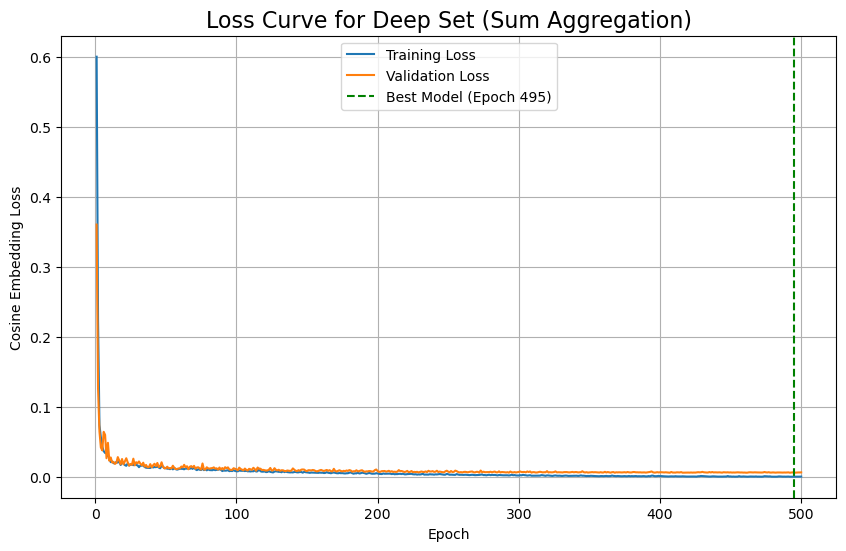


--- 7: Evaluating Best 'sum' Model on Test Set ---


Evaluating (sum): 100%|██████████| 16/16 [00:00<00:00, 29.30it/s]


Saved error vs events plot to 'error_vs_events_sum.png'


========================= TRAINING MODEL WITH 'MAX' AGGREGATION =========================

--- 4: Initializing Model (max) and Training Components ---
Using device: cuda:0

--- 5: Starting Training with Validation ---


Epoch 1/500 | Train Loss: 0.958546 | Val Loss: 0.813324


Epoch 2/500 | Train Loss: 0.659733 | Val Loss: 0.579276


Epoch 3/500 | Train Loss: 0.647252 | Val Loss: 0.764669


Epoch 4/500 | Train Loss: 0.543507 | Val Loss: 0.477645


Epoch 5/500 | Train Loss: 0.426901 | Val Loss: 0.370133


Epoch 6/500 | Train Loss: 0.267334 | Val Loss: 0.219305


Epoch 7/500 | Train Loss: 0.154404 | Val Loss: 0.131087


Epoch 8/500 | Train Loss: 0.095944 | Val Loss: 0.101693


Epoch 9/500 | Train Loss: 0.076588 | Val Loss: 0.074261


Epoch 10/500 | Train Loss: 0.064672 | Val Loss: 0.080274


Epoch 11/500 | Train Loss: 0.050249 | Val Loss: 0.064444


Epoch 12/500 | Train Loss: 0.043210 | Val Loss: 0.050695


Epoch 13/500 | Train Loss: 0.035625 | Val Loss: 0.044861


Epoch 14/500 | Train Loss: 0.038529 | Val Loss: 0.040305


Epoch 15/500 | Train Loss: 0.028953 | Val Loss: 0.043348


Epoch 16/500 | Train Loss: 0.028025 | Val Loss: 0.038171


Epoch 17/500 | Train Loss: 0.027188 | Val Loss: 0.034007


Epoch 18/500 | Train Loss: 0.024445 | Val Loss: 0.033492


Epoch 19/500 | Train Loss: 0.021837 | Val Loss: 0.037552


Epoch 20/500 | Train Loss: 0.020925 | Val Loss: 0.036432


Epoch 21/500 | Train Loss: 0.021060 | Val Loss: 0.040953


Epoch 22/500 | Train Loss: 0.018437 | Val Loss: 0.030392


Epoch 23/500 | Train Loss: 0.016908 | Val Loss: 0.033122


Epoch 24/500 | Train Loss: 0.019557 | Val Loss: 0.035911


Epoch 25/500 | Train Loss: 0.017766 | Val Loss: 0.030736


Epoch 26/500 | Train Loss: 0.017036 | Val Loss: 0.029412


Epoch 27/500 | Train Loss: 0.014508 | Val Loss: 0.027853


Epoch 28/500 | Train Loss: 0.014341 | Val Loss: 0.030657


Epoch 29/500 | Train Loss: 0.015772 | Val Loss: 0.031064


Epoch 30/500 | Train Loss: 0.012918 | Val Loss: 0.027477


Epoch 31/500 | Train Loss: 0.012515 | Val Loss: 0.030182


Epoch 32/500 | Train Loss: 0.011319 | Val Loss: 0.027414


Epoch 33/500 | Train Loss: 0.010903 | Val Loss: 0.029655


Epoch 34/500 | Train Loss: 0.012185 | Val Loss: 0.032789


Epoch 35/500 | Train Loss: 0.014391 | Val Loss: 0.027617


Epoch 36/500 | Train Loss: 0.011164 | Val Loss: 0.026870


Epoch 37/500 | Train Loss: 0.009944 | Val Loss: 0.028226


Epoch 38/500 | Train Loss: 0.009859 | Val Loss: 0.028279


Epoch 39/500 | Train Loss: 0.009598 | Val Loss: 0.029443


Epoch 40/500 | Train Loss: 0.009152 | Val Loss: 0.027206


Epoch 41/500 | Train Loss: 0.008983 | Val Loss: 0.028950


Epoch 42/500 | Train Loss: 0.007957 | Val Loss: 0.026646


Epoch 43/500 | Train Loss: 0.008922 | Val Loss: 0.030654


Epoch 44/500 | Train Loss: 0.008555 | Val Loss: 0.028651


Epoch 45/500 | Train Loss: 0.008396 | Val Loss: 0.030492


Epoch 46/500 | Train Loss: 0.007230 | Val Loss: 0.025944


Epoch 47/500 | Train Loss: 0.007557 | Val Loss: 0.027662


Epoch 48/500 | Train Loss: 0.006691 | Val Loss: 0.030886


Epoch 49/500 | Train Loss: 0.008674 | Val Loss: 0.026911


Epoch 50/500 | Train Loss: 0.007728 | Val Loss: 0.026922


Epoch 51/500 | Train Loss: 0.006019 | Val Loss: 0.029291


Epoch 52/500 | Train Loss: 0.006962 | Val Loss: 0.027086


Epoch 53/500 | Train Loss: 0.006981 | Val Loss: 0.025289


Epoch 54/500 | Train Loss: 0.005921 | Val Loss: 0.025446


Epoch 55/500 | Train Loss: 0.004857 | Val Loss: 0.025642


Epoch 56/500 | Train Loss: 0.004508 | Val Loss: 0.026425


Epoch 57/500 | Train Loss: 0.005230 | Val Loss: 0.025990


Epoch 58/500 | Train Loss: 0.004228 | Val Loss: 0.028127


Epoch 59/500 | Train Loss: 0.006293 | Val Loss: 0.025546


Epoch 60/500 | Train Loss: 0.005394 | Val Loss: 0.031328


Epoch 61/500 | Train Loss: 0.005707 | Val Loss: 0.028519


Epoch 62/500 | Train Loss: 0.006214 | Val Loss: 0.025077


Epoch 63/500 | Train Loss: 0.005082 | Val Loss: 0.026579


Epoch 64/500 | Train Loss: 0.003430 | Val Loss: 0.025652


Epoch 65/500 | Train Loss: 0.003520 | Val Loss: 0.025017


Epoch 66/500 | Train Loss: 0.003173 | Val Loss: 0.027388


Epoch 67/500 | Train Loss: 0.003557 | Val Loss: 0.027233


Epoch 68/500 | Train Loss: 0.004660 | Val Loss: 0.025994


Epoch 69/500 | Train Loss: 0.004204 | Val Loss: 0.030880


Epoch 70/500 | Train Loss: 0.004862 | Val Loss: 0.026258


Epoch 71/500 | Train Loss: 0.004044 | Val Loss: 0.025145


Epoch 72/500 | Train Loss: 0.003057 | Val Loss: 0.026105


Epoch 73/500 | Train Loss: 0.002867 | Val Loss: 0.024788


Epoch 74/500 | Train Loss: 0.002969 | Val Loss: 0.024941


Epoch 75/500 | Train Loss: 0.003413 | Val Loss: 0.029376


Epoch 76/500 | Train Loss: 0.004475 | Val Loss: 0.025953


Epoch 77/500 | Train Loss: 0.003525 | Val Loss: 0.026270


Epoch 78/500 | Train Loss: 0.003564 | Val Loss: 0.026738


Epoch 79/500 | Train Loss: 0.003942 | Val Loss: 0.027734


Epoch 80/500 | Train Loss: 0.002777 | Val Loss: 0.025201


Epoch 81/500 | Train Loss: 0.003354 | Val Loss: 0.027303


Epoch 82/500 | Train Loss: 0.002671 | Val Loss: 0.024796


Epoch 83/500 | Train Loss: 0.002498 | Val Loss: 0.026394


Epoch 84/500 | Train Loss: 0.003195 | Val Loss: 0.025582


Epoch 85/500 | Train Loss: 0.002018 | Val Loss: 0.025221


Epoch 86/500 | Train Loss: 0.002803 | Val Loss: 0.028428


Epoch 87/500 | Train Loss: 0.002371 | Val Loss: 0.024698


Epoch 88/500 | Train Loss: 0.003089 | Val Loss: 0.024229


Epoch 89/500 | Train Loss: 0.001815 | Val Loss: 0.027009


Epoch 90/500 | Train Loss: 0.003523 | Val Loss: 0.025170


Epoch 91/500 | Train Loss: 0.002746 | Val Loss: 0.025065


Epoch 92/500 | Train Loss: 0.001617 | Val Loss: 0.024260


Epoch 93/500 | Train Loss: 0.002324 | Val Loss: 0.025655


Epoch 94/500 | Train Loss: 0.002781 | Val Loss: 0.024417


Epoch 95/500 | Train Loss: 0.002367 | Val Loss: 0.024069


Epoch 96/500 | Train Loss: 0.002339 | Val Loss: 0.028608


Epoch 97/500 | Train Loss: 0.002444 | Val Loss: 0.025143


Epoch 98/500 | Train Loss: 0.002254 | Val Loss: 0.025498


Epoch 99/500 | Train Loss: 0.001313 | Val Loss: 0.025261


Epoch 100/500 | Train Loss: 0.001276 | Val Loss: 0.024351


Epoch 101/500 | Train Loss: 0.001396 | Val Loss: 0.024557


Epoch 102/500 | Train Loss: 0.001436 | Val Loss: 0.024835


Epoch 103/500 | Train Loss: 0.001398 | Val Loss: 0.026246


Epoch 104/500 | Train Loss: 0.001981 | Val Loss: 0.028010


Epoch 105/500 | Train Loss: 0.002427 | Val Loss: 0.024709


Epoch 106/500 | Train Loss: 0.002588 | Val Loss: 0.025757


Epoch 107/500 | Train Loss: 0.002180 | Val Loss: 0.024859


Epoch 108/500 | Train Loss: 0.001715 | Val Loss: 0.026712


Epoch 109/500 | Train Loss: 0.002065 | Val Loss: 0.023982


Epoch 110/500 | Train Loss: 0.001079 | Val Loss: 0.024305


Epoch 111/500 | Train Loss: 0.001703 | Val Loss: 0.024556


Epoch 112/500 | Train Loss: 0.001510 | Val Loss: 0.024734


Epoch 113/500 | Train Loss: 0.001220 | Val Loss: 0.025212


Epoch 114/500 | Train Loss: 0.002063 | Val Loss: 0.024914


Epoch 115/500 | Train Loss: 0.001106 | Val Loss: 0.024565


Epoch 116/500 | Train Loss: 0.001479 | Val Loss: 0.023925


Epoch 117/500 | Train Loss: 0.001016 | Val Loss: 0.025768


Epoch 118/500 | Train Loss: 0.001869 | Val Loss: 0.027604


Epoch 119/500 | Train Loss: 0.002887 | Val Loss: 0.024988


Epoch 120/500 | Train Loss: 0.001749 | Val Loss: 0.024664


Epoch 121/500 | Train Loss: 0.001879 | Val Loss: 0.024114


Epoch 122/500 | Train Loss: 0.001222 | Val Loss: 0.024536


Epoch 123/500 | Train Loss: 0.000844 | Val Loss: 0.024050


Epoch 124/500 | Train Loss: 0.001774 | Val Loss: 0.024446


Epoch 125/500 | Train Loss: 0.001218 | Val Loss: 0.024995


Epoch 126/500 | Train Loss: 0.001223 | Val Loss: 0.024883


Epoch 127/500 | Train Loss: 0.001561 | Val Loss: 0.023716


Epoch 128/500 | Train Loss: 0.001402 | Val Loss: 0.024280


Epoch 129/500 | Train Loss: 0.001003 | Val Loss: 0.024602


Epoch 130/500 | Train Loss: 0.001315 | Val Loss: 0.023898


Epoch 131/500 | Train Loss: 0.001153 | Val Loss: 0.026067


Epoch 132/500 | Train Loss: 0.001154 | Val Loss: 0.025043


Epoch 133/500 | Train Loss: 0.001092 | Val Loss: 0.024479


Epoch 134/500 | Train Loss: 0.001884 | Val Loss: 0.023621


Epoch 135/500 | Train Loss: 0.001428 | Val Loss: 0.024077


Epoch 136/500 | Train Loss: 0.001265 | Val Loss: 0.023807


Epoch 137/500 | Train Loss: 0.001750 | Val Loss: 0.024270


Epoch 138/500 | Train Loss: 0.000986 | Val Loss: 0.024343


Epoch 139/500 | Train Loss: 0.000892 | Val Loss: 0.024286


Epoch 140/500 | Train Loss: 0.000947 | Val Loss: 0.023703


Epoch 141/500 | Train Loss: 0.000788 | Val Loss: 0.023625


Epoch 142/500 | Train Loss: 0.000445 | Val Loss: 0.024052


Epoch 143/500 | Train Loss: 0.000838 | Val Loss: 0.023772


Epoch 144/500 | Train Loss: 0.001480 | Val Loss: 0.023674


Epoch 145/500 | Train Loss: 0.002298 | Val Loss: 0.025147


Epoch 146/500 | Train Loss: 0.001503 | Val Loss: 0.026362


Epoch 147/500 | Train Loss: 0.001632 | Val Loss: 0.024331


Epoch 148/500 | Train Loss: 0.001348 | Val Loss: 0.024025


Epoch 149/500 | Train Loss: 0.000918 | Val Loss: 0.023263


Epoch 150/500 | Train Loss: 0.000659 | Val Loss: 0.023300


Epoch 151/500 | Train Loss: 0.000451 | Val Loss: 0.023815


Epoch 152/500 | Train Loss: 0.001177 | Val Loss: 0.023274


Epoch 153/500 | Train Loss: 0.000396 | Val Loss: 0.024015


Epoch 154/500 | Train Loss: 0.000469 | Val Loss: 0.023346


Epoch 155/500 | Train Loss: 0.000494 | Val Loss: 0.024876


Epoch 156/500 | Train Loss: 0.001499 | Val Loss: 0.024061


Epoch 157/500 | Train Loss: 0.000957 | Val Loss: 0.023426


Epoch 158/500 | Train Loss: 0.000864 | Val Loss: 0.023308


Epoch 159/500 | Train Loss: 0.001259 | Val Loss: 0.023846


Epoch 160/500 | Train Loss: 0.002104 | Val Loss: 0.023871


Epoch 161/500 | Train Loss: 0.001139 | Val Loss: 0.024681


Epoch 162/500 | Train Loss: 0.000788 | Val Loss: 0.023128


Epoch 163/500 | Train Loss: 0.000612 | Val Loss: 0.022903


Epoch 164/500 | Train Loss: 0.000773 | Val Loss: 0.023557


Epoch 165/500 | Train Loss: 0.000811 | Val Loss: 0.023028


Epoch 166/500 | Train Loss: 0.002198 | Val Loss: 0.023293


Epoch 167/500 | Train Loss: 0.000829 | Val Loss: 0.023870


Epoch 168/500 | Train Loss: 0.002747 | Val Loss: 0.023280


Epoch 169/500 | Train Loss: 0.001920 | Val Loss: 0.024123


Epoch 170/500 | Train Loss: 0.000928 | Val Loss: 0.022812


Epoch 171/500 | Train Loss: 0.000884 | Val Loss: 0.023665


Epoch 172/500 | Train Loss: 0.000898 | Val Loss: 0.022469


Epoch 173/500 | Train Loss: 0.000688 | Val Loss: 0.023124


Epoch 174/500 | Train Loss: 0.000436 | Val Loss: 0.022792


Epoch 175/500 | Train Loss: 0.000568 | Val Loss: 0.023095


Epoch 176/500 | Train Loss: 0.000388 | Val Loss: 0.022616


Epoch 177/500 | Train Loss: 0.000518 | Val Loss: 0.023253


Epoch 178/500 | Train Loss: 0.001408 | Val Loss: 0.023167


Epoch 179/500 | Train Loss: 0.000843 | Val Loss: 0.022756


Epoch 180/500 | Train Loss: 0.000761 | Val Loss: 0.022785


Epoch 181/500 | Train Loss: 0.000708 | Val Loss: 0.022824


Epoch 182/500 | Train Loss: 0.000850 | Val Loss: 0.023777


Epoch 183/500 | Train Loss: 0.000828 | Val Loss: 0.023045


Epoch 184/500 | Train Loss: 0.000536 | Val Loss: 0.022726


Epoch 185/500 | Train Loss: 0.000382 | Val Loss: 0.024437


Epoch 186/500 | Train Loss: 0.000873 | Val Loss: 0.023802


Epoch 187/500 | Train Loss: 0.000561 | Val Loss: 0.022878


Epoch 188/500 | Train Loss: 0.000498 | Val Loss: 0.022943


Epoch 189/500 | Train Loss: 0.000312 | Val Loss: 0.022758


Epoch 190/500 | Train Loss: 0.000397 | Val Loss: 0.023123


Epoch 191/500 | Train Loss: 0.000878 | Val Loss: 0.023522


Epoch 192/500 | Train Loss: 0.000928 | Val Loss: 0.024132


Epoch 193/500 | Train Loss: 0.000857 | Val Loss: 0.023819


Epoch 194/500 | Train Loss: 0.000886 | Val Loss: 0.023184


Epoch 195/500 | Train Loss: 0.001723 | Val Loss: 0.023793


Epoch 196/500 | Train Loss: 0.000870 | Val Loss: 0.022426


Epoch 197/500 | Train Loss: 0.000561 | Val Loss: 0.022802


Epoch 198/500 | Train Loss: 0.000318 | Val Loss: 0.022604


Epoch 199/500 | Train Loss: 0.000272 | Val Loss: 0.022370


Epoch 200/500 | Train Loss: 0.000453 | Val Loss: 0.023396


Epoch 201/500 | Train Loss: 0.001207 | Val Loss: 0.023256


Epoch 202/500 | Train Loss: 0.000690 | Val Loss: 0.022991


Epoch 203/500 | Train Loss: 0.000805 | Val Loss: 0.022485


Epoch 204/500 | Train Loss: 0.000422 | Val Loss: 0.022678


Epoch 205/500 | Train Loss: 0.000458 | Val Loss: 0.022277


Epoch 206/500 | Train Loss: 0.000575 | Val Loss: 0.022668


Epoch 207/500 | Train Loss: 0.000710 | Val Loss: 0.023930


Epoch 208/500 | Train Loss: 0.000677 | Val Loss: 0.023461


Epoch 209/500 | Train Loss: 0.000659 | Val Loss: 0.022429


Epoch 210/500 | Train Loss: 0.000680 | Val Loss: 0.023231


Epoch 211/500 | Train Loss: 0.000592 | Val Loss: 0.023482


Epoch 212/500 | Train Loss: 0.001731 | Val Loss: 0.023192


Epoch 213/500 | Train Loss: 0.001466 | Val Loss: 0.024218


Epoch 214/500 | Train Loss: 0.001183 | Val Loss: 0.023505


Epoch 215/500 | Train Loss: 0.001052 | Val Loss: 0.023500


Epoch 216/500 | Train Loss: 0.001535 | Val Loss: 0.023912


Epoch 217/500 | Train Loss: 0.001724 | Val Loss: 0.022562


Epoch 218/500 | Train Loss: 0.000631 | Val Loss: 0.022280


Epoch 219/500 | Train Loss: 0.000532 | Val Loss: 0.022045


Epoch 220/500 | Train Loss: 0.000398 | Val Loss: 0.022254


Epoch 221/500 | Train Loss: 0.000283 | Val Loss: 0.022142


Epoch 222/500 | Train Loss: 0.000274 | Val Loss: 0.022228


Epoch 223/500 | Train Loss: 0.000217 | Val Loss: 0.022335


Epoch 224/500 | Train Loss: 0.000247 | Val Loss: 0.022220


Epoch 225/500 | Train Loss: 0.000430 | Val Loss: 0.023055


Epoch 226/500 | Train Loss: 0.000374 | Val Loss: 0.023019


Epoch 227/500 | Train Loss: 0.000326 | Val Loss: 0.022371


Epoch 228/500 | Train Loss: 0.000262 | Val Loss: 0.022593


Epoch 229/500 | Train Loss: 0.000871 | Val Loss: 0.022260


Epoch 230/500 | Train Loss: 0.000500 | Val Loss: 0.022115


Epoch 231/500 | Train Loss: 0.000345 | Val Loss: 0.022129


Epoch 232/500 | Train Loss: 0.000378 | Val Loss: 0.022914


Epoch 233/500 | Train Loss: 0.000965 | Val Loss: 0.022094


Epoch 234/500 | Train Loss: 0.000800 | Val Loss: 0.024227


Epoch 235/500 | Train Loss: 0.001772 | Val Loss: 0.022769


Epoch 236/500 | Train Loss: 0.001908 | Val Loss: 0.021714


Epoch 237/500 | Train Loss: 0.000948 | Val Loss: 0.022113


Epoch 238/500 | Train Loss: 0.000783 | Val Loss: 0.022322


Epoch 239/500 | Train Loss: 0.000317 | Val Loss: 0.021890


Epoch 240/500 | Train Loss: 0.000223 | Val Loss: 0.021909


Epoch 241/500 | Train Loss: 0.000323 | Val Loss: 0.022303


Epoch 242/500 | Train Loss: 0.000217 | Val Loss: 0.022114


Epoch 243/500 | Train Loss: 0.000192 | Val Loss: 0.021997


Epoch 244/500 | Train Loss: 0.000404 | Val Loss: 0.022562


Epoch 245/500 | Train Loss: 0.001263 | Val Loss: 0.025451


Epoch 246/500 | Train Loss: 0.001226 | Val Loss: 0.022480


Epoch 247/500 | Train Loss: 0.000534 | Val Loss: 0.022624


Epoch 248/500 | Train Loss: 0.000334 | Val Loss: 0.021962


Epoch 249/500 | Train Loss: 0.000188 | Val Loss: 0.022179


Epoch 250/500 | Train Loss: 0.000242 | Val Loss: 0.021916


Epoch 251/500 | Train Loss: 0.000281 | Val Loss: 0.022137


Epoch 252/500 | Train Loss: 0.001152 | Val Loss: 0.022601


Epoch 253/500 | Train Loss: 0.000761 | Val Loss: 0.021999


Epoch 254/500 | Train Loss: 0.000979 | Val Loss: 0.023263


Epoch 255/500 | Train Loss: 0.000977 | Val Loss: 0.021911


Epoch 256/500 | Train Loss: 0.000402 | Val Loss: 0.021813


Epoch 257/500 | Train Loss: 0.000315 | Val Loss: 0.021641


Epoch 258/500 | Train Loss: 0.000263 | Val Loss: 0.021803


Epoch 259/500 | Train Loss: 0.000338 | Val Loss: 0.021896


Epoch 260/500 | Train Loss: 0.000663 | Val Loss: 0.022416


Epoch 261/500 | Train Loss: 0.000463 | Val Loss: 0.022163


Epoch 262/500 | Train Loss: 0.000299 | Val Loss: 0.021804


Epoch 263/500 | Train Loss: 0.000286 | Val Loss: 0.022130


Epoch 264/500 | Train Loss: 0.000698 | Val Loss: 0.021840


Epoch 265/500 | Train Loss: 0.000711 | Val Loss: 0.022736


Epoch 266/500 | Train Loss: 0.001329 | Val Loss: 0.022991


Epoch 267/500 | Train Loss: 0.001282 | Val Loss: 0.021652


Epoch 268/500 | Train Loss: 0.001318 | Val Loss: 0.024142


Epoch 269/500 | Train Loss: 0.000748 | Val Loss: 0.021804


Epoch 270/500 | Train Loss: 0.000555 | Val Loss: 0.022055


Epoch 271/500 | Train Loss: 0.000381 | Val Loss: 0.021756


Epoch 272/500 | Train Loss: 0.000204 | Val Loss: 0.021763


Epoch 273/500 | Train Loss: 0.000123 | Val Loss: 0.021648


Epoch 274/500 | Train Loss: 0.000118 | Val Loss: 0.021602


Epoch 275/500 | Train Loss: 0.000176 | Val Loss: 0.021646


Epoch 276/500 | Train Loss: 0.000110 | Val Loss: 0.021711


Epoch 277/500 | Train Loss: 0.000128 | Val Loss: 0.021950


Epoch 278/500 | Train Loss: 0.000150 | Val Loss: 0.021571


Epoch 279/500 | Train Loss: 0.000240 | Val Loss: 0.021588


Epoch 280/500 | Train Loss: 0.000449 | Val Loss: 0.022053


Epoch 281/500 | Train Loss: 0.000233 | Val Loss: 0.021650


Epoch 282/500 | Train Loss: 0.000163 | Val Loss: 0.021868


Epoch 283/500 | Train Loss: 0.000287 | Val Loss: 0.021807


Epoch 284/500 | Train Loss: 0.001037 | Val Loss: 0.021892


Epoch 285/500 | Train Loss: 0.003011 | Val Loss: 0.022791


Epoch 286/500 | Train Loss: 0.001460 | Val Loss: 0.022053


Epoch 287/500 | Train Loss: 0.000873 | Val Loss: 0.021615


Epoch 288/500 | Train Loss: 0.001096 | Val Loss: 0.021631


Epoch 289/500 | Train Loss: 0.000614 | Val Loss: 0.022686


Epoch 290/500 | Train Loss: 0.000485 | Val Loss: 0.021425


Epoch 291/500 | Train Loss: 0.000267 | Val Loss: 0.021721


Epoch 292/500 | Train Loss: 0.000202 | Val Loss: 0.021450


Epoch 293/500 | Train Loss: 0.000108 | Val Loss: 0.021388


Epoch 294/500 | Train Loss: 0.000125 | Val Loss: 0.021533


Epoch 295/500 | Train Loss: 0.000146 | Val Loss: 0.021711


Epoch 296/500 | Train Loss: 0.000151 | Val Loss: 0.021451


Epoch 297/500 | Train Loss: 0.000137 | Val Loss: 0.021532


Epoch 298/500 | Train Loss: 0.000353 | Val Loss: 0.021615


Epoch 299/500 | Train Loss: 0.000665 | Val Loss: 0.021671


Epoch 300/500 | Train Loss: 0.000458 | Val Loss: 0.021664


Epoch 301/500 | Train Loss: 0.000681 | Val Loss: 0.022968


Epoch 302/500 | Train Loss: 0.000777 | Val Loss: 0.022928


Epoch 303/500 | Train Loss: 0.000618 | Val Loss: 0.021068


Epoch 304/500 | Train Loss: 0.000247 | Val Loss: 0.021290


Epoch 305/500 | Train Loss: 0.000276 | Val Loss: 0.021234


Epoch 306/500 | Train Loss: 0.000253 | Val Loss: 0.021286


Epoch 307/500 | Train Loss: 0.000204 | Val Loss: 0.021369


Epoch 308/500 | Train Loss: 0.000197 | Val Loss: 0.021451


Epoch 309/500 | Train Loss: 0.000308 | Val Loss: 0.021500


Epoch 310/500 | Train Loss: 0.000432 | Val Loss: 0.021803


Epoch 311/500 | Train Loss: 0.000713 | Val Loss: 0.022314


Epoch 312/500 | Train Loss: 0.000915 | Val Loss: 0.021649


Epoch 313/500 | Train Loss: 0.001280 | Val Loss: 0.021692


Epoch 314/500 | Train Loss: 0.000764 | Val Loss: 0.022264


Epoch 315/500 | Train Loss: 0.000393 | Val Loss: 0.021366


Epoch 316/500 | Train Loss: 0.000214 | Val Loss: 0.021095


Epoch 317/500 | Train Loss: 0.000164 | Val Loss: 0.021369


Epoch 318/500 | Train Loss: 0.000253 | Val Loss: 0.021473


Epoch 319/500 | Train Loss: 0.000268 | Val Loss: 0.021484


Epoch 320/500 | Train Loss: 0.000255 | Val Loss: 0.021548


Epoch 321/500 | Train Loss: 0.000174 | Val Loss: 0.021277


Epoch 322/500 | Train Loss: 0.000218 | Val Loss: 0.021494


Epoch 323/500 | Train Loss: 0.000690 | Val Loss: 0.022637


Epoch 324/500 | Train Loss: 0.002381 | Val Loss: 0.023867


Epoch 325/500 | Train Loss: 0.001396 | Val Loss: 0.021485


Epoch 326/500 | Train Loss: 0.000468 | Val Loss: 0.021306


Epoch 327/500 | Train Loss: 0.000198 | Val Loss: 0.021127


Epoch 328/500 | Train Loss: 0.000127 | Val Loss: 0.021561


Epoch 329/500 | Train Loss: 0.000329 | Val Loss: 0.020969


Epoch 330/500 | Train Loss: 0.000189 | Val Loss: 0.021022


Epoch 331/500 | Train Loss: 0.000160 | Val Loss: 0.021252


Epoch 332/500 | Train Loss: 0.000167 | Val Loss: 0.021223


Epoch 333/500 | Train Loss: 0.000149 | Val Loss: 0.021208


Epoch 334/500 | Train Loss: 0.000115 | Val Loss: 0.021013


Epoch 335/500 | Train Loss: 0.000207 | Val Loss: 0.021620


Epoch 336/500 | Train Loss: 0.000550 | Val Loss: 0.021154


Epoch 337/500 | Train Loss: 0.000479 | Val Loss: 0.021230


Epoch 338/500 | Train Loss: 0.000250 | Val Loss: 0.021181


Epoch 339/500 | Train Loss: 0.000243 | Val Loss: 0.021353


Epoch 340/500 | Train Loss: 0.000301 | Val Loss: 0.021437


Epoch 341/500 | Train Loss: 0.000339 | Val Loss: 0.021332


Epoch 342/500 | Train Loss: 0.000658 | Val Loss: 0.022580


Epoch 343/500 | Train Loss: 0.000709 | Val Loss: 0.020990


Epoch 344/500 | Train Loss: 0.000425 | Val Loss: 0.021456


Epoch 345/500 | Train Loss: 0.000305 | Val Loss: 0.020973


Epoch 346/500 | Train Loss: 0.000274 | Val Loss: 0.021040


Epoch 347/500 | Train Loss: 0.000236 | Val Loss: 0.020809


Epoch 348/500 | Train Loss: 0.000270 | Val Loss: 0.021861


Epoch 349/500 | Train Loss: 0.000308 | Val Loss: 0.020972


Epoch 350/500 | Train Loss: 0.000274 | Val Loss: 0.020920


Epoch 351/500 | Train Loss: 0.001218 | Val Loss: 0.021224


Epoch 352/500 | Train Loss: 0.001055 | Val Loss: 0.020888


Epoch 353/500 | Train Loss: 0.000466 | Val Loss: 0.020971


Epoch 354/500 | Train Loss: 0.000545 | Val Loss: 0.020934


Epoch 355/500 | Train Loss: 0.000591 | Val Loss: 0.020767


Epoch 356/500 | Train Loss: 0.000295 | Val Loss: 0.020900


Epoch 357/500 | Train Loss: 0.000276 | Val Loss: 0.020654


Epoch 358/500 | Train Loss: 0.000239 | Val Loss: 0.021288


Epoch 359/500 | Train Loss: 0.000704 | Val Loss: 0.021817


Epoch 360/500 | Train Loss: 0.000859 | Val Loss: 0.022341


Epoch 361/500 | Train Loss: 0.000825 | Val Loss: 0.020822


Epoch 362/500 | Train Loss: 0.000306 | Val Loss: 0.020863


Epoch 363/500 | Train Loss: 0.000268 | Val Loss: 0.020829


Epoch 364/500 | Train Loss: 0.000133 | Val Loss: 0.020740


Epoch 365/500 | Train Loss: 0.000116 | Val Loss: 0.021014


Epoch 366/500 | Train Loss: 0.000135 | Val Loss: 0.020772


Epoch 367/500 | Train Loss: 0.000112 | Val Loss: 0.020667


Epoch 368/500 | Train Loss: 0.000301 | Val Loss: 0.020829


Epoch 369/500 | Train Loss: 0.000313 | Val Loss: 0.020752


Epoch 370/500 | Train Loss: 0.000173 | Val Loss: 0.020845


Epoch 371/500 | Train Loss: 0.000151 | Val Loss: 0.020811


Epoch 372/500 | Train Loss: 0.000149 | Val Loss: 0.020573


Epoch 373/500 | Train Loss: 0.000163 | Val Loss: 0.021014


Epoch 374/500 | Train Loss: 0.000238 | Val Loss: 0.020566


Epoch 375/500 | Train Loss: 0.000135 | Val Loss: 0.020677


Epoch 376/500 | Train Loss: 0.000267 | Val Loss: 0.021156


Epoch 377/500 | Train Loss: 0.000530 | Val Loss: 0.020803


Epoch 378/500 | Train Loss: 0.000948 | Val Loss: 0.020893


Epoch 379/500 | Train Loss: 0.000965 | Val Loss: 0.020935


Epoch 380/500 | Train Loss: 0.000755 | Val Loss: 0.020746


Epoch 381/500 | Train Loss: 0.000501 | Val Loss: 0.020694


Epoch 382/500 | Train Loss: 0.000394 | Val Loss: 0.020608


Epoch 383/500 | Train Loss: 0.000298 | Val Loss: 0.021127


Epoch 384/500 | Train Loss: 0.000510 | Val Loss: 0.020389


Epoch 385/500 | Train Loss: 0.000285 | Val Loss: 0.020532


Epoch 386/500 | Train Loss: 0.000268 | Val Loss: 0.020355


Epoch 387/500 | Train Loss: 0.000182 | Val Loss: 0.020468


Epoch 388/500 | Train Loss: 0.000158 | Val Loss: 0.020541


Epoch 389/500 | Train Loss: 0.000114 | Val Loss: 0.020720


Epoch 390/500 | Train Loss: 0.000139 | Val Loss: 0.020447


Epoch 391/500 | Train Loss: 0.000234 | Val Loss: 0.020355


Epoch 392/500 | Train Loss: 0.000371 | Val Loss: 0.020808


Epoch 393/500 | Train Loss: 0.000428 | Val Loss: 0.021180


Epoch 394/500 | Train Loss: 0.000267 | Val Loss: 0.020460


Epoch 395/500 | Train Loss: 0.000289 | Val Loss: 0.020651


Epoch 396/500 | Train Loss: 0.000466 | Val Loss: 0.021351


Epoch 397/500 | Train Loss: 0.000657 | Val Loss: 0.020728


Epoch 398/500 | Train Loss: 0.000761 | Val Loss: 0.021034


Epoch 399/500 | Train Loss: 0.000850 | Val Loss: 0.021597


Epoch 400/500 | Train Loss: 0.000801 | Val Loss: 0.021814


Epoch 401/500 | Train Loss: 0.000521 | Val Loss: 0.020200


Epoch 402/500 | Train Loss: 0.000385 | Val Loss: 0.020334


Epoch 403/500 | Train Loss: 0.000247 | Val Loss: 0.020120


Epoch 404/500 | Train Loss: 0.000127 | Val Loss: 0.020464


Epoch 405/500 | Train Loss: 0.000095 | Val Loss: 0.020329


Epoch 406/500 | Train Loss: 0.000112 | Val Loss: 0.020362


Epoch 407/500 | Train Loss: 0.000152 | Val Loss: 0.020428


Epoch 408/500 | Train Loss: 0.000147 | Val Loss: 0.020300


Epoch 409/500 | Train Loss: 0.000289 | Val Loss: 0.020565


Epoch 410/500 | Train Loss: 0.000315 | Val Loss: 0.020990


Epoch 411/500 | Train Loss: 0.000224 | Val Loss: 0.020260


Epoch 412/500 | Train Loss: 0.000269 | Val Loss: 0.021511


Epoch 413/500 | Train Loss: 0.000730 | Val Loss: 0.021262


Epoch 414/500 | Train Loss: 0.000828 | Val Loss: 0.020820


Epoch 415/500 | Train Loss: 0.000662 | Val Loss: 0.020739


Epoch 416/500 | Train Loss: 0.000498 | Val Loss: 0.020348


Epoch 417/500 | Train Loss: 0.000348 | Val Loss: 0.020519


Epoch 418/500 | Train Loss: 0.000281 | Val Loss: 0.020489


Epoch 419/500 | Train Loss: 0.000129 | Val Loss: 0.020191


Epoch 420/500 | Train Loss: 0.000068 | Val Loss: 0.020216


Epoch 421/500 | Train Loss: 0.000036 | Val Loss: 0.020212


Epoch 422/500 | Train Loss: 0.000032 | Val Loss: 0.020215


Epoch 423/500 | Train Loss: 0.000037 | Val Loss: 0.020178


Epoch 424/500 | Train Loss: 0.000035 | Val Loss: 0.020183


Epoch 425/500 | Train Loss: 0.000048 | Val Loss: 0.020269


Epoch 426/500 | Train Loss: 0.000123 | Val Loss: 0.020298


Epoch 427/500 | Train Loss: 0.000357 | Val Loss: 0.020160


Epoch 428/500 | Train Loss: 0.000487 | Val Loss: 0.020598


Epoch 429/500 | Train Loss: 0.000470 | Val Loss: 0.020366


Epoch 430/500 | Train Loss: 0.000355 | Val Loss: 0.020825


Epoch 431/500 | Train Loss: 0.000471 | Val Loss: 0.020472


Epoch 432/500 | Train Loss: 0.000713 | Val Loss: 0.020613


Epoch 433/500 | Train Loss: 0.000666 | Val Loss: 0.020283


Epoch 434/500 | Train Loss: 0.000736 | Val Loss: 0.020544


Epoch 435/500 | Train Loss: 0.000879 | Val Loss: 0.021938


Epoch 436/500 | Train Loss: 0.000780 | Val Loss: 0.020016


Epoch 437/500 | Train Loss: 0.000277 | Val Loss: 0.020433


Epoch 438/500 | Train Loss: 0.000320 | Val Loss: 0.019963


Epoch 439/500 | Train Loss: 0.000137 | Val Loss: 0.020085


Epoch 440/500 | Train Loss: 0.000079 | Val Loss: 0.019962


Epoch 441/500 | Train Loss: 0.000106 | Val Loss: 0.020214


Epoch 442/500 | Train Loss: 0.000165 | Val Loss: 0.020224


Epoch 443/500 | Train Loss: 0.000111 | Val Loss: 0.020024


Epoch 444/500 | Train Loss: 0.000078 | Val Loss: 0.020284


Epoch 445/500 | Train Loss: 0.000113 | Val Loss: 0.020015


Epoch 446/500 | Train Loss: 0.000218 | Val Loss: 0.020269


Epoch 447/500 | Train Loss: 0.000485 | Val Loss: 0.020548


Epoch 448/500 | Train Loss: 0.000858 | Val Loss: 0.021014


Epoch 449/500 | Train Loss: 0.000722 | Val Loss: 0.020270


Epoch 450/500 | Train Loss: 0.000515 | Val Loss: 0.019976


Epoch 451/500 | Train Loss: 0.000241 | Val Loss: 0.020156


Epoch 452/500 | Train Loss: 0.000195 | Val Loss: 0.019927


Epoch 453/500 | Train Loss: 0.000169 | Val Loss: 0.019852


Epoch 454/500 | Train Loss: 0.000101 | Val Loss: 0.019905


Epoch 455/500 | Train Loss: 0.000083 | Val Loss: 0.019896


Epoch 456/500 | Train Loss: 0.000110 | Val Loss: 0.020329


Epoch 457/500 | Train Loss: 0.000146 | Val Loss: 0.020338


Epoch 458/500 | Train Loss: 0.000160 | Val Loss: 0.019893


Epoch 459/500 | Train Loss: 0.000138 | Val Loss: 0.020052


Epoch 460/500 | Train Loss: 0.000262 | Val Loss: 0.020116


Epoch 461/500 | Train Loss: 0.000347 | Val Loss: 0.020059


Epoch 462/500 | Train Loss: 0.000585 | Val Loss: 0.020221


Epoch 463/500 | Train Loss: 0.000450 | Val Loss: 0.020293


Epoch 464/500 | Train Loss: 0.000534 | Val Loss: 0.020124


Epoch 465/500 | Train Loss: 0.000618 | Val Loss: 0.020323


Epoch 466/500 | Train Loss: 0.000545 | Val Loss: 0.020436


Epoch 467/500 | Train Loss: 0.000448 | Val Loss: 0.019865


Epoch 468/500 | Train Loss: 0.000314 | Val Loss: 0.019899


Epoch 469/500 | Train Loss: 0.000221 | Val Loss: 0.019925


Epoch 470/500 | Train Loss: 0.000122 | Val Loss: 0.019730


Epoch 471/500 | Train Loss: 0.000061 | Val Loss: 0.019796


Epoch 472/500 | Train Loss: 0.000078 | Val Loss: 0.019935


Epoch 473/500 | Train Loss: 0.000099 | Val Loss: 0.019757


Epoch 474/500 | Train Loss: 0.000094 | Val Loss: 0.019815


Epoch 475/500 | Train Loss: 0.000096 | Val Loss: 0.019832


Epoch 476/500 | Train Loss: 0.000148 | Val Loss: 0.019745


Epoch 477/500 | Train Loss: 0.000155 | Val Loss: 0.019790


Epoch 478/500 | Train Loss: 0.000091 | Val Loss: 0.019817


Epoch 479/500 | Train Loss: 0.000130 | Val Loss: 0.019814


Epoch 480/500 | Train Loss: 0.000262 | Val Loss: 0.019739


Epoch 481/500 | Train Loss: 0.000282 | Val Loss: 0.019626


Epoch 482/500 | Train Loss: 0.000399 | Val Loss: 0.020511


Epoch 483/500 | Train Loss: 0.000381 | Val Loss: 0.020063


Epoch 484/500 | Train Loss: 0.000629 | Val Loss: 0.019770


Epoch 485/500 | Train Loss: 0.000384 | Val Loss: 0.019847


Epoch 486/500 | Train Loss: 0.000333 | Val Loss: 0.019857


Epoch 487/500 | Train Loss: 0.000281 | Val Loss: 0.020223


Epoch 488/500 | Train Loss: 0.000357 | Val Loss: 0.019609


Epoch 489/500 | Train Loss: 0.000269 | Val Loss: 0.019638


Epoch 490/500 | Train Loss: 0.000170 | Val Loss: 0.019470


Epoch 491/500 | Train Loss: 0.000187 | Val Loss: 0.019744


Epoch 492/500 | Train Loss: 0.000276 | Val Loss: 0.019670


Epoch 493/500 | Train Loss: 0.000220 | Val Loss: 0.019745


Epoch 494/500 | Train Loss: 0.000366 | Val Loss: 0.019750


Epoch 495/500 | Train Loss: 0.000277 | Val Loss: 0.019626


Epoch 496/500 | Train Loss: 0.000169 | Val Loss: 0.019506


Epoch 497/500 | Train Loss: 0.000109 | Val Loss: 0.019446


Epoch 498/500 | Train Loss: 0.000081 | Val Loss: 0.019423


Epoch 499/500 | Train Loss: 0.000123 | Val Loss: 0.019584


Epoch 500/500 | Train Loss: 0.000147 | Val Loss: 0.019604

--- Training Complete for 'max' model. Best epoch: 498 (Val Loss: 0.019423) ---

--- 6: Displaying Loss Curve Plot for 'max' model ---


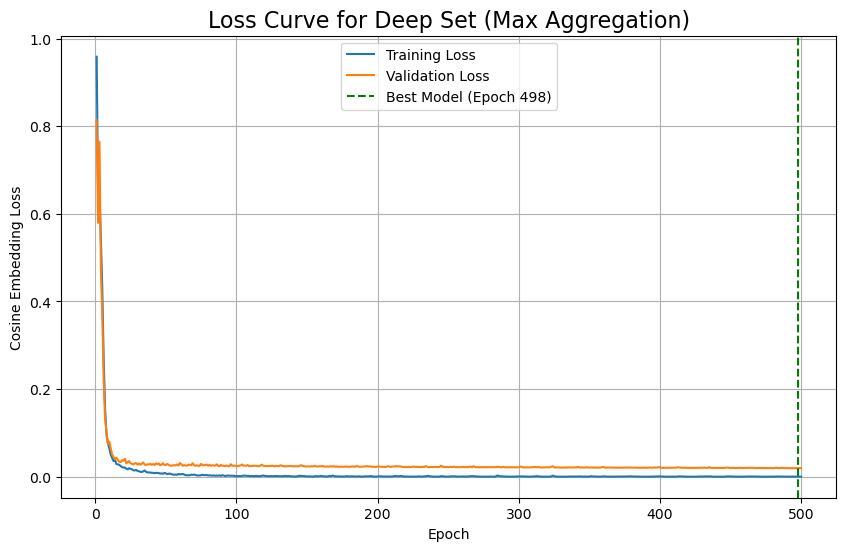


--- 7: Evaluating Best 'max' Model on Test Set ---


Evaluating (max): 100%|██████████| 16/16 [00:00<00:00, 28.72it/s]


Saved error vs events plot to 'error_vs_events_max.png'


========================= TRAINING MODEL WITH 'MEAN' AGGREGATION =========================

--- 4: Initializing Model (mean) and Training Components ---
Using device: cuda:0

--- 5: Starting Training with Validation ---


Epoch 1/500 | Train Loss: 0.941760 | Val Loss: 0.750680


Epoch 2/500 | Train Loss: 0.555496 | Val Loss: 0.529200


Epoch 3/500 | Train Loss: 0.513336 | Val Loss: 0.522860


Epoch 4/500 | Train Loss: 0.492794 | Val Loss: 0.490587


Epoch 5/500 | Train Loss: 0.424501 | Val Loss: 0.325442


Epoch 6/500 | Train Loss: 0.214672 | Val Loss: 0.122558


Epoch 7/500 | Train Loss: 0.077282 | Val Loss: 0.053984


Epoch 8/500 | Train Loss: 0.048207 | Val Loss: 0.056122


Epoch 9/500 | Train Loss: 0.044192 | Val Loss: 0.042018


Epoch 10/500 | Train Loss: 0.034022 | Val Loss: 0.041522


Epoch 11/500 | Train Loss: 0.034052 | Val Loss: 0.038613


Epoch 12/500 | Train Loss: 0.031296 | Val Loss: 0.031436


Epoch 13/500 | Train Loss: 0.029159 | Val Loss: 0.048720


Epoch 14/500 | Train Loss: 0.027604 | Val Loss: 0.039029


Epoch 15/500 | Train Loss: 0.024851 | Val Loss: 0.025572


Epoch 16/500 | Train Loss: 0.023119 | Val Loss: 0.023944


Epoch 17/500 | Train Loss: 0.022109 | Val Loss: 0.034216


Epoch 18/500 | Train Loss: 0.023555 | Val Loss: 0.021410


Epoch 19/500 | Train Loss: 0.020884 | Val Loss: 0.021783


Epoch 20/500 | Train Loss: 0.019327 | Val Loss: 0.024052


Epoch 21/500 | Train Loss: 0.018934 | Val Loss: 0.020811


Epoch 22/500 | Train Loss: 0.017791 | Val Loss: 0.017875


Epoch 23/500 | Train Loss: 0.020373 | Val Loss: 0.022090


Epoch 24/500 | Train Loss: 0.018386 | Val Loss: 0.021731


Epoch 25/500 | Train Loss: 0.018560 | Val Loss: 0.016710


Epoch 26/500 | Train Loss: 0.017994 | Val Loss: 0.020223


Epoch 27/500 | Train Loss: 0.016839 | Val Loss: 0.018294


Epoch 28/500 | Train Loss: 0.015971 | Val Loss: 0.017135


Epoch 29/500 | Train Loss: 0.015452 | Val Loss: 0.016950


Epoch 30/500 | Train Loss: 0.016698 | Val Loss: 0.018237


Epoch 31/500 | Train Loss: 0.014811 | Val Loss: 0.017035


Epoch 32/500 | Train Loss: 0.016004 | Val Loss: 0.016580


Epoch 33/500 | Train Loss: 0.014733 | Val Loss: 0.015309


Epoch 34/500 | Train Loss: 0.014483 | Val Loss: 0.019043


Epoch 35/500 | Train Loss: 0.017246 | Val Loss: 0.028903


Epoch 36/500 | Train Loss: 0.016902 | Val Loss: 0.020644


Epoch 37/500 | Train Loss: 0.017169 | Val Loss: 0.015852


Epoch 38/500 | Train Loss: 0.015346 | Val Loss: 0.020274


Epoch 39/500 | Train Loss: 0.016781 | Val Loss: 0.016793


Epoch 40/500 | Train Loss: 0.014701 | Val Loss: 0.019235


Epoch 41/500 | Train Loss: 0.013752 | Val Loss: 0.015289


Epoch 42/500 | Train Loss: 0.013469 | Val Loss: 0.014193


Epoch 43/500 | Train Loss: 0.012997 | Val Loss: 0.014036


Epoch 44/500 | Train Loss: 0.013629 | Val Loss: 0.014864


Epoch 45/500 | Train Loss: 0.014903 | Val Loss: 0.014194


Epoch 46/500 | Train Loss: 0.013460 | Val Loss: 0.016398


Epoch 47/500 | Train Loss: 0.014118 | Val Loss: 0.015454


Epoch 48/500 | Train Loss: 0.013635 | Val Loss: 0.015194


Epoch 49/500 | Train Loss: 0.013685 | Val Loss: 0.014614


Epoch 50/500 | Train Loss: 0.014016 | Val Loss: 0.017288


Epoch 51/500 | Train Loss: 0.013557 | Val Loss: 0.014162


Epoch 52/500 | Train Loss: 0.015730 | Val Loss: 0.015763


Epoch 53/500 | Train Loss: 0.014217 | Val Loss: 0.015754


Epoch 54/500 | Train Loss: 0.012504 | Val Loss: 0.016803


Epoch 55/500 | Train Loss: 0.013635 | Val Loss: 0.019074


Epoch 56/500 | Train Loss: 0.012467 | Val Loss: 0.013059


Epoch 57/500 | Train Loss: 0.012851 | Val Loss: 0.013841


Epoch 58/500 | Train Loss: 0.011196 | Val Loss: 0.014215


Epoch 59/500 | Train Loss: 0.014957 | Val Loss: 0.017883


Epoch 60/500 | Train Loss: 0.014764 | Val Loss: 0.024712


Epoch 61/500 | Train Loss: 0.013357 | Val Loss: 0.014042


Epoch 62/500 | Train Loss: 0.012250 | Val Loss: 0.013217


Epoch 63/500 | Train Loss: 0.013331 | Val Loss: 0.013117


Epoch 64/500 | Train Loss: 0.011318 | Val Loss: 0.015257


Epoch 65/500 | Train Loss: 0.011815 | Val Loss: 0.015244


Epoch 66/500 | Train Loss: 0.011072 | Val Loss: 0.016321


Epoch 67/500 | Train Loss: 0.011601 | Val Loss: 0.013707


Epoch 68/500 | Train Loss: 0.012043 | Val Loss: 0.019596


Epoch 69/500 | Train Loss: 0.014946 | Val Loss: 0.012992


Epoch 70/500 | Train Loss: 0.013443 | Val Loss: 0.014328


Epoch 71/500 | Train Loss: 0.011309 | Val Loss: 0.013561


Epoch 72/500 | Train Loss: 0.011129 | Val Loss: 0.014077


Epoch 73/500 | Train Loss: 0.012509 | Val Loss: 0.014973


Epoch 74/500 | Train Loss: 0.011249 | Val Loss: 0.013220


Epoch 75/500 | Train Loss: 0.010928 | Val Loss: 0.011891


Epoch 76/500 | Train Loss: 0.011438 | Val Loss: 0.014324


Epoch 77/500 | Train Loss: 0.011508 | Val Loss: 0.013735


Epoch 78/500 | Train Loss: 0.010892 | Val Loss: 0.014161


Epoch 79/500 | Train Loss: 0.012075 | Val Loss: 0.015854


Epoch 80/500 | Train Loss: 0.012086 | Val Loss: 0.013795


Epoch 81/500 | Train Loss: 0.010983 | Val Loss: 0.012401


Epoch 82/500 | Train Loss: 0.010448 | Val Loss: 0.011680


Epoch 83/500 | Train Loss: 0.010867 | Val Loss: 0.012892


Epoch 84/500 | Train Loss: 0.009971 | Val Loss: 0.014409


Epoch 85/500 | Train Loss: 0.011543 | Val Loss: 0.022260


Epoch 86/500 | Train Loss: 0.012125 | Val Loss: 0.012520


Epoch 87/500 | Train Loss: 0.010540 | Val Loss: 0.012954


Epoch 88/500 | Train Loss: 0.011094 | Val Loss: 0.013362


Epoch 89/500 | Train Loss: 0.010427 | Val Loss: 0.013777


Epoch 90/500 | Train Loss: 0.009765 | Val Loss: 0.013922


Epoch 91/500 | Train Loss: 0.010067 | Val Loss: 0.011080


Epoch 92/500 | Train Loss: 0.010386 | Val Loss: 0.013282


Epoch 93/500 | Train Loss: 0.010286 | Val Loss: 0.012927


Epoch 94/500 | Train Loss: 0.010515 | Val Loss: 0.011970


Epoch 95/500 | Train Loss: 0.010501 | Val Loss: 0.011727


Epoch 96/500 | Train Loss: 0.010380 | Val Loss: 0.015286


Epoch 97/500 | Train Loss: 0.010080 | Val Loss: 0.011957


Epoch 98/500 | Train Loss: 0.009954 | Val Loss: 0.011874


Epoch 99/500 | Train Loss: 0.011810 | Val Loss: 0.017923


Epoch 100/500 | Train Loss: 0.010775 | Val Loss: 0.010864


Epoch 101/500 | Train Loss: 0.009722 | Val Loss: 0.010952


Epoch 102/500 | Train Loss: 0.010137 | Val Loss: 0.014185


Epoch 103/500 | Train Loss: 0.009097 | Val Loss: 0.012053


Epoch 104/500 | Train Loss: 0.010826 | Val Loss: 0.013096


Epoch 105/500 | Train Loss: 0.010131 | Val Loss: 0.013071


Epoch 106/500 | Train Loss: 0.011718 | Val Loss: 0.013050


Epoch 107/500 | Train Loss: 0.012003 | Val Loss: 0.012450


Epoch 108/500 | Train Loss: 0.009232 | Val Loss: 0.012332


Epoch 109/500 | Train Loss: 0.009252 | Val Loss: 0.011008


Epoch 110/500 | Train Loss: 0.009279 | Val Loss: 0.010424


Epoch 111/500 | Train Loss: 0.009293 | Val Loss: 0.010640


Epoch 112/500 | Train Loss: 0.008830 | Val Loss: 0.011459


Epoch 113/500 | Train Loss: 0.009163 | Val Loss: 0.010989


Epoch 114/500 | Train Loss: 0.008871 | Val Loss: 0.011567


Epoch 115/500 | Train Loss: 0.009211 | Val Loss: 0.012491


Epoch 116/500 | Train Loss: 0.009589 | Val Loss: 0.010625


Epoch 117/500 | Train Loss: 0.008435 | Val Loss: 0.013545


Epoch 118/500 | Train Loss: 0.009046 | Val Loss: 0.011717


Epoch 119/500 | Train Loss: 0.008819 | Val Loss: 0.013370


Epoch 120/500 | Train Loss: 0.008983 | Val Loss: 0.012006


Epoch 121/500 | Train Loss: 0.009179 | Val Loss: 0.010442


Epoch 122/500 | Train Loss: 0.009183 | Val Loss: 0.013710


Epoch 123/500 | Train Loss: 0.009742 | Val Loss: 0.013187


Epoch 124/500 | Train Loss: 0.008966 | Val Loss: 0.011217


Epoch 125/500 | Train Loss: 0.009481 | Val Loss: 0.010671


Epoch 126/500 | Train Loss: 0.008757 | Val Loss: 0.012559


Epoch 127/500 | Train Loss: 0.009727 | Val Loss: 0.011305


Epoch 128/500 | Train Loss: 0.007937 | Val Loss: 0.010217


Epoch 129/500 | Train Loss: 0.009174 | Val Loss: 0.011126


Epoch 130/500 | Train Loss: 0.010187 | Val Loss: 0.011393


Epoch 131/500 | Train Loss: 0.008093 | Val Loss: 0.009908


Epoch 132/500 | Train Loss: 0.009002 | Val Loss: 0.014290


Epoch 133/500 | Train Loss: 0.009746 | Val Loss: 0.017340


Epoch 134/500 | Train Loss: 0.009623 | Val Loss: 0.010699


Epoch 135/500 | Train Loss: 0.008691 | Val Loss: 0.010016


Epoch 136/500 | Train Loss: 0.009283 | Val Loss: 0.014700


Epoch 137/500 | Train Loss: 0.009513 | Val Loss: 0.015173


Epoch 138/500 | Train Loss: 0.010109 | Val Loss: 0.009707


Epoch 139/500 | Train Loss: 0.008131 | Val Loss: 0.011365


Epoch 140/500 | Train Loss: 0.008090 | Val Loss: 0.009642


Epoch 141/500 | Train Loss: 0.008878 | Val Loss: 0.012696


Epoch 142/500 | Train Loss: 0.008401 | Val Loss: 0.010518


Epoch 143/500 | Train Loss: 0.008540 | Val Loss: 0.009934


Epoch 144/500 | Train Loss: 0.008146 | Val Loss: 0.010799


Epoch 145/500 | Train Loss: 0.008391 | Val Loss: 0.012101


Epoch 146/500 | Train Loss: 0.008561 | Val Loss: 0.011464


Epoch 147/500 | Train Loss: 0.007879 | Val Loss: 0.009968


Epoch 148/500 | Train Loss: 0.008363 | Val Loss: 0.011484


Epoch 149/500 | Train Loss: 0.008347 | Val Loss: 0.010013


Epoch 150/500 | Train Loss: 0.008000 | Val Loss: 0.011224


Epoch 151/500 | Train Loss: 0.008305 | Val Loss: 0.010729


Epoch 152/500 | Train Loss: 0.008922 | Val Loss: 0.010595


Epoch 153/500 | Train Loss: 0.007475 | Val Loss: 0.011299


Epoch 154/500 | Train Loss: 0.007667 | Val Loss: 0.010139


Epoch 155/500 | Train Loss: 0.007972 | Val Loss: 0.010632


Epoch 156/500 | Train Loss: 0.007838 | Val Loss: 0.010364


Epoch 157/500 | Train Loss: 0.007609 | Val Loss: 0.009878


Epoch 158/500 | Train Loss: 0.008466 | Val Loss: 0.009427


Epoch 159/500 | Train Loss: 0.007928 | Val Loss: 0.009160


Epoch 160/500 | Train Loss: 0.007140 | Val Loss: 0.009909


Epoch 161/500 | Train Loss: 0.007247 | Val Loss: 0.009302


Epoch 162/500 | Train Loss: 0.007231 | Val Loss: 0.009556


Epoch 163/500 | Train Loss: 0.007592 | Val Loss: 0.009151


Epoch 164/500 | Train Loss: 0.007040 | Val Loss: 0.009033


Epoch 165/500 | Train Loss: 0.007201 | Val Loss: 0.014004


Epoch 166/500 | Train Loss: 0.007471 | Val Loss: 0.012221


Epoch 167/500 | Train Loss: 0.007829 | Val Loss: 0.009627


Epoch 168/500 | Train Loss: 0.007194 | Val Loss: 0.009656


Epoch 169/500 | Train Loss: 0.007426 | Val Loss: 0.009353


Epoch 170/500 | Train Loss: 0.007245 | Val Loss: 0.009035


Epoch 171/500 | Train Loss: 0.007433 | Val Loss: 0.011048


Epoch 172/500 | Train Loss: 0.007670 | Val Loss: 0.009822


Epoch 173/500 | Train Loss: 0.007502 | Val Loss: 0.011592


Epoch 174/500 | Train Loss: 0.007704 | Val Loss: 0.011069


Epoch 175/500 | Train Loss: 0.007126 | Val Loss: 0.009132


Epoch 176/500 | Train Loss: 0.006743 | Val Loss: 0.010382


Epoch 177/500 | Train Loss: 0.007234 | Val Loss: 0.009534


Epoch 178/500 | Train Loss: 0.007078 | Val Loss: 0.009714


Epoch 179/500 | Train Loss: 0.007115 | Val Loss: 0.010705


Epoch 180/500 | Train Loss: 0.007245 | Val Loss: 0.009419


Epoch 181/500 | Train Loss: 0.007133 | Val Loss: 0.009461


Epoch 182/500 | Train Loss: 0.007382 | Val Loss: 0.010594


Epoch 183/500 | Train Loss: 0.007023 | Val Loss: 0.009603


Epoch 184/500 | Train Loss: 0.006453 | Val Loss: 0.008665


Epoch 185/500 | Train Loss: 0.006606 | Val Loss: 0.011365


Epoch 186/500 | Train Loss: 0.007031 | Val Loss: 0.008819


Epoch 187/500 | Train Loss: 0.006615 | Val Loss: 0.010315


Epoch 188/500 | Train Loss: 0.007093 | Val Loss: 0.009991


Epoch 189/500 | Train Loss: 0.007107 | Val Loss: 0.009546


Epoch 190/500 | Train Loss: 0.007142 | Val Loss: 0.010193


Epoch 191/500 | Train Loss: 0.006626 | Val Loss: 0.009557


Epoch 192/500 | Train Loss: 0.007222 | Val Loss: 0.009820


Epoch 193/500 | Train Loss: 0.007242 | Val Loss: 0.009502


Epoch 194/500 | Train Loss: 0.006272 | Val Loss: 0.009025


Epoch 195/500 | Train Loss: 0.006774 | Val Loss: 0.009604


Epoch 196/500 | Train Loss: 0.006598 | Val Loss: 0.010164


Epoch 197/500 | Train Loss: 0.006985 | Val Loss: 0.009270


Epoch 198/500 | Train Loss: 0.008284 | Val Loss: 0.011783


Epoch 199/500 | Train Loss: 0.006502 | Val Loss: 0.009278


Epoch 200/500 | Train Loss: 0.006797 | Val Loss: 0.012194


Epoch 201/500 | Train Loss: 0.006730 | Val Loss: 0.008676


Epoch 202/500 | Train Loss: 0.006387 | Val Loss: 0.009403


Epoch 203/500 | Train Loss: 0.006376 | Val Loss: 0.009729


Epoch 204/500 | Train Loss: 0.006852 | Val Loss: 0.008698


Epoch 205/500 | Train Loss: 0.006627 | Val Loss: 0.009412


Epoch 206/500 | Train Loss: 0.006019 | Val Loss: 0.008743


Epoch 207/500 | Train Loss: 0.006278 | Val Loss: 0.008735


Epoch 208/500 | Train Loss: 0.006694 | Val Loss: 0.009871


Epoch 209/500 | Train Loss: 0.006370 | Val Loss: 0.010061


Epoch 210/500 | Train Loss: 0.006526 | Val Loss: 0.009706


Epoch 211/500 | Train Loss: 0.006012 | Val Loss: 0.009286


Epoch 212/500 | Train Loss: 0.006492 | Val Loss: 0.010338


Epoch 213/500 | Train Loss: 0.006550 | Val Loss: 0.008783


Epoch 214/500 | Train Loss: 0.005924 | Val Loss: 0.009439


Epoch 215/500 | Train Loss: 0.006144 | Val Loss: 0.009130


Epoch 216/500 | Train Loss: 0.006066 | Val Loss: 0.009473


Epoch 217/500 | Train Loss: 0.006220 | Val Loss: 0.009377


Epoch 218/500 | Train Loss: 0.006110 | Val Loss: 0.008853


Epoch 219/500 | Train Loss: 0.006109 | Val Loss: 0.009019


Epoch 220/500 | Train Loss: 0.006442 | Val Loss: 0.009152


Epoch 221/500 | Train Loss: 0.006477 | Val Loss: 0.008419


Epoch 222/500 | Train Loss: 0.006454 | Val Loss: 0.009010


Epoch 223/500 | Train Loss: 0.006860 | Val Loss: 0.010296


Epoch 224/500 | Train Loss: 0.005919 | Val Loss: 0.008501


Epoch 225/500 | Train Loss: 0.006126 | Val Loss: 0.008726


Epoch 226/500 | Train Loss: 0.006490 | Val Loss: 0.008488


Epoch 227/500 | Train Loss: 0.005517 | Val Loss: 0.009010


Epoch 228/500 | Train Loss: 0.005768 | Val Loss: 0.008944


Epoch 229/500 | Train Loss: 0.005778 | Val Loss: 0.008450


Epoch 230/500 | Train Loss: 0.005510 | Val Loss: 0.008607


Epoch 231/500 | Train Loss: 0.005852 | Val Loss: 0.009360


Epoch 232/500 | Train Loss: 0.005768 | Val Loss: 0.011781


Epoch 233/500 | Train Loss: 0.005934 | Val Loss: 0.008247


Epoch 234/500 | Train Loss: 0.005626 | Val Loss: 0.009022


Epoch 235/500 | Train Loss: 0.005940 | Val Loss: 0.009048


Epoch 236/500 | Train Loss: 0.006485 | Val Loss: 0.009434


Epoch 237/500 | Train Loss: 0.006242 | Val Loss: 0.010052


Epoch 238/500 | Train Loss: 0.005552 | Val Loss: 0.009109


Epoch 239/500 | Train Loss: 0.005887 | Val Loss: 0.008711


Epoch 240/500 | Train Loss: 0.005945 | Val Loss: 0.010123


Epoch 241/500 | Train Loss: 0.005726 | Val Loss: 0.008638


Epoch 242/500 | Train Loss: 0.005690 | Val Loss: 0.008079


Epoch 243/500 | Train Loss: 0.005890 | Val Loss: 0.009564


Epoch 244/500 | Train Loss: 0.005617 | Val Loss: 0.008653


Epoch 245/500 | Train Loss: 0.005416 | Val Loss: 0.008415


Epoch 246/500 | Train Loss: 0.005641 | Val Loss: 0.009336


Epoch 247/500 | Train Loss: 0.005255 | Val Loss: 0.008265


Epoch 248/500 | Train Loss: 0.005573 | Val Loss: 0.008783


Epoch 249/500 | Train Loss: 0.005420 | Val Loss: 0.009152


Epoch 250/500 | Train Loss: 0.005285 | Val Loss: 0.009126


Epoch 251/500 | Train Loss: 0.005237 | Val Loss: 0.009099


Epoch 252/500 | Train Loss: 0.005159 | Val Loss: 0.009751


Epoch 253/500 | Train Loss: 0.006037 | Val Loss: 0.008095


Epoch 254/500 | Train Loss: 0.005132 | Val Loss: 0.008842


Epoch 255/500 | Train Loss: 0.005440 | Val Loss: 0.009050


Epoch 256/500 | Train Loss: 0.006317 | Val Loss: 0.008672


Epoch 257/500 | Train Loss: 0.004994 | Val Loss: 0.010782


Epoch 258/500 | Train Loss: 0.005279 | Val Loss: 0.008695


Epoch 259/500 | Train Loss: 0.005474 | Val Loss: 0.009197


Epoch 260/500 | Train Loss: 0.004890 | Val Loss: 0.008039


Epoch 261/500 | Train Loss: 0.005450 | Val Loss: 0.008637


Epoch 262/500 | Train Loss: 0.005122 | Val Loss: 0.007996


Epoch 263/500 | Train Loss: 0.006040 | Val Loss: 0.008431


Epoch 264/500 | Train Loss: 0.005292 | Val Loss: 0.008398


Epoch 265/500 | Train Loss: 0.005210 | Val Loss: 0.008283


Epoch 266/500 | Train Loss: 0.005559 | Val Loss: 0.008826


Epoch 267/500 | Train Loss: 0.005235 | Val Loss: 0.007924


Epoch 268/500 | Train Loss: 0.006208 | Val Loss: 0.008420


Epoch 269/500 | Train Loss: 0.005221 | Val Loss: 0.009605


Epoch 270/500 | Train Loss: 0.005624 | Val Loss: 0.009148


Epoch 271/500 | Train Loss: 0.005170 | Val Loss: 0.008268


Epoch 272/500 | Train Loss: 0.004841 | Val Loss: 0.008236


Epoch 273/500 | Train Loss: 0.005049 | Val Loss: 0.008596


Epoch 274/500 | Train Loss: 0.005184 | Val Loss: 0.007754


Epoch 275/500 | Train Loss: 0.005091 | Val Loss: 0.008046


Epoch 276/500 | Train Loss: 0.004956 | Val Loss: 0.008441


Epoch 277/500 | Train Loss: 0.004957 | Val Loss: 0.008445


Epoch 278/500 | Train Loss: 0.004826 | Val Loss: 0.008803


Epoch 279/500 | Train Loss: 0.004796 | Val Loss: 0.008365


Epoch 280/500 | Train Loss: 0.004863 | Val Loss: 0.008054


Epoch 281/500 | Train Loss: 0.004990 | Val Loss: 0.008006


Epoch 282/500 | Train Loss: 0.005150 | Val Loss: 0.009034


Epoch 283/500 | Train Loss: 0.005097 | Val Loss: 0.007596


Epoch 284/500 | Train Loss: 0.004603 | Val Loss: 0.008448


Epoch 285/500 | Train Loss: 0.004709 | Val Loss: 0.007728


Epoch 286/500 | Train Loss: 0.005072 | Val Loss: 0.008144


Epoch 287/500 | Train Loss: 0.004797 | Val Loss: 0.008234


Epoch 288/500 | Train Loss: 0.004768 | Val Loss: 0.007868


Epoch 289/500 | Train Loss: 0.004630 | Val Loss: 0.008018


Epoch 290/500 | Train Loss: 0.004370 | Val Loss: 0.008186


Epoch 291/500 | Train Loss: 0.004912 | Val Loss: 0.008871


Epoch 292/500 | Train Loss: 0.004966 | Val Loss: 0.008084


Epoch 293/500 | Train Loss: 0.004901 | Val Loss: 0.011227


Epoch 294/500 | Train Loss: 0.004818 | Val Loss: 0.007543


Epoch 295/500 | Train Loss: 0.004518 | Val Loss: 0.007933


Epoch 296/500 | Train Loss: 0.004338 | Val Loss: 0.008039


Epoch 297/500 | Train Loss: 0.004505 | Val Loss: 0.007759


Epoch 298/500 | Train Loss: 0.004407 | Val Loss: 0.007890


Epoch 299/500 | Train Loss: 0.004837 | Val Loss: 0.008200


Epoch 300/500 | Train Loss: 0.004845 | Val Loss: 0.012772


Epoch 301/500 | Train Loss: 0.006126 | Val Loss: 0.008410


Epoch 302/500 | Train Loss: 0.005053 | Val Loss: 0.008492


Epoch 303/500 | Train Loss: 0.004559 | Val Loss: 0.007256


Epoch 304/500 | Train Loss: 0.005052 | Val Loss: 0.008974


Epoch 305/500 | Train Loss: 0.004584 | Val Loss: 0.008058


Epoch 306/500 | Train Loss: 0.004496 | Val Loss: 0.008014


Epoch 307/500 | Train Loss: 0.004538 | Val Loss: 0.008113


Epoch 308/500 | Train Loss: 0.004602 | Val Loss: 0.007981


Epoch 309/500 | Train Loss: 0.004129 | Val Loss: 0.007727


Epoch 310/500 | Train Loss: 0.003906 | Val Loss: 0.007808


Epoch 311/500 | Train Loss: 0.004138 | Val Loss: 0.008076


Epoch 312/500 | Train Loss: 0.004467 | Val Loss: 0.009688


Epoch 313/500 | Train Loss: 0.004527 | Val Loss: 0.007319


Epoch 314/500 | Train Loss: 0.004467 | Val Loss: 0.008181


Epoch 315/500 | Train Loss: 0.004628 | Val Loss: 0.008120


Epoch 316/500 | Train Loss: 0.004127 | Val Loss: 0.007690


Epoch 317/500 | Train Loss: 0.004163 | Val Loss: 0.008060


Epoch 318/500 | Train Loss: 0.004824 | Val Loss: 0.008269


Epoch 319/500 | Train Loss: 0.004344 | Val Loss: 0.008192


Epoch 320/500 | Train Loss: 0.004216 | Val Loss: 0.007287


Epoch 321/500 | Train Loss: 0.005274 | Val Loss: 0.010132


Epoch 322/500 | Train Loss: 0.004565 | Val Loss: 0.007492


Epoch 323/500 | Train Loss: 0.004252 | Val Loss: 0.007396


Epoch 324/500 | Train Loss: 0.004143 | Val Loss: 0.007697


Epoch 325/500 | Train Loss: 0.004057 | Val Loss: 0.007320


Epoch 326/500 | Train Loss: 0.004224 | Val Loss: 0.008023


Epoch 327/500 | Train Loss: 0.003996 | Val Loss: 0.008308


Epoch 328/500 | Train Loss: 0.004210 | Val Loss: 0.008023


Epoch 329/500 | Train Loss: 0.003862 | Val Loss: 0.007898


Epoch 330/500 | Train Loss: 0.004285 | Val Loss: 0.007884


Epoch 331/500 | Train Loss: 0.004222 | Val Loss: 0.008270


Epoch 332/500 | Train Loss: 0.004095 | Val Loss: 0.007554


Epoch 333/500 | Train Loss: 0.004190 | Val Loss: 0.007398


Epoch 334/500 | Train Loss: 0.004581 | Val Loss: 0.007510


Epoch 335/500 | Train Loss: 0.004486 | Val Loss: 0.007664


Epoch 336/500 | Train Loss: 0.003745 | Val Loss: 0.008515


Epoch 337/500 | Train Loss: 0.003873 | Val Loss: 0.008040


Epoch 338/500 | Train Loss: 0.003938 | Val Loss: 0.007607


Epoch 339/500 | Train Loss: 0.003868 | Val Loss: 0.008194


Epoch 340/500 | Train Loss: 0.004011 | Val Loss: 0.007389


Epoch 341/500 | Train Loss: 0.003698 | Val Loss: 0.008005


Epoch 342/500 | Train Loss: 0.004217 | Val Loss: 0.007417


Epoch 343/500 | Train Loss: 0.004219 | Val Loss: 0.008074


Epoch 344/500 | Train Loss: 0.003799 | Val Loss: 0.007133


Epoch 345/500 | Train Loss: 0.003687 | Val Loss: 0.007597


Epoch 346/500 | Train Loss: 0.003740 | Val Loss: 0.007499


Epoch 347/500 | Train Loss: 0.004017 | Val Loss: 0.007330


Epoch 348/500 | Train Loss: 0.003580 | Val Loss: 0.007960


Epoch 349/500 | Train Loss: 0.003929 | Val Loss: 0.009135


Epoch 350/500 | Train Loss: 0.003717 | Val Loss: 0.007411


Epoch 351/500 | Train Loss: 0.003571 | Val Loss: 0.007601


Epoch 352/500 | Train Loss: 0.003786 | Val Loss: 0.007891


Epoch 353/500 | Train Loss: 0.003968 | Val Loss: 0.007648


Epoch 354/500 | Train Loss: 0.003697 | Val Loss: 0.007356


Epoch 355/500 | Train Loss: 0.003587 | Val Loss: 0.008840


Epoch 356/500 | Train Loss: 0.004195 | Val Loss: 0.008181


Epoch 357/500 | Train Loss: 0.003913 | Val Loss: 0.007981


Epoch 358/500 | Train Loss: 0.003685 | Val Loss: 0.008220


Epoch 359/500 | Train Loss: 0.003785 | Val Loss: 0.008927


Epoch 360/500 | Train Loss: 0.003708 | Val Loss: 0.007432


Epoch 361/500 | Train Loss: 0.004144 | Val Loss: 0.007606


Epoch 362/500 | Train Loss: 0.003808 | Val Loss: 0.007300


Epoch 363/500 | Train Loss: 0.003394 | Val Loss: 0.007323


Epoch 364/500 | Train Loss: 0.003438 | Val Loss: 0.007345


Epoch 365/500 | Train Loss: 0.003540 | Val Loss: 0.007798


Epoch 366/500 | Train Loss: 0.003381 | Val Loss: 0.006917


Epoch 367/500 | Train Loss: 0.003230 | Val Loss: 0.007932


Epoch 368/500 | Train Loss: 0.003509 | Val Loss: 0.007221


Epoch 369/500 | Train Loss: 0.003444 | Val Loss: 0.007798


Epoch 370/500 | Train Loss: 0.003423 | Val Loss: 0.007206


Epoch 371/500 | Train Loss: 0.003711 | Val Loss: 0.009955


Epoch 372/500 | Train Loss: 0.003398 | Val Loss: 0.006954


Epoch 373/500 | Train Loss: 0.003225 | Val Loss: 0.007029


Epoch 374/500 | Train Loss: 0.003274 | Val Loss: 0.007192


Epoch 375/500 | Train Loss: 0.003605 | Val Loss: 0.007796


Epoch 376/500 | Train Loss: 0.003354 | Val Loss: 0.007006


Epoch 377/500 | Train Loss: 0.003393 | Val Loss: 0.008658


Epoch 378/500 | Train Loss: 0.003535 | Val Loss: 0.007582


Epoch 379/500 | Train Loss: 0.003222 | Val Loss: 0.007394


Epoch 380/500 | Train Loss: 0.003351 | Val Loss: 0.007206


Epoch 381/500 | Train Loss: 0.002848 | Val Loss: 0.007054


Epoch 382/500 | Train Loss: 0.003214 | Val Loss: 0.007278


Epoch 383/500 | Train Loss: 0.003216 | Val Loss: 0.007242


Epoch 384/500 | Train Loss: 0.003468 | Val Loss: 0.006973


Epoch 385/500 | Train Loss: 0.003296 | Val Loss: 0.007414


Epoch 386/500 | Train Loss: 0.003333 | Val Loss: 0.007030


Epoch 387/500 | Train Loss: 0.002981 | Val Loss: 0.007433


Epoch 388/500 | Train Loss: 0.003235 | Val Loss: 0.007138


Epoch 389/500 | Train Loss: 0.003329 | Val Loss: 0.006934


Epoch 390/500 | Train Loss: 0.003008 | Val Loss: 0.006873


Epoch 391/500 | Train Loss: 0.003066 | Val Loss: 0.007002


Epoch 392/500 | Train Loss: 0.003035 | Val Loss: 0.007337


Epoch 393/500 | Train Loss: 0.003388 | Val Loss: 0.007943


Epoch 394/500 | Train Loss: 0.003231 | Val Loss: 0.006965


Epoch 395/500 | Train Loss: 0.002826 | Val Loss: 0.007454


Epoch 396/500 | Train Loss: 0.003164 | Val Loss: 0.007322


Epoch 397/500 | Train Loss: 0.003366 | Val Loss: 0.009846


Epoch 398/500 | Train Loss: 0.004203 | Val Loss: 0.007685


Epoch 399/500 | Train Loss: 0.003375 | Val Loss: 0.006803


Epoch 400/500 | Train Loss: 0.002985 | Val Loss: 0.007269


Epoch 401/500 | Train Loss: 0.003225 | Val Loss: 0.007640


Epoch 402/500 | Train Loss: 0.003005 | Val Loss: 0.007590


Epoch 403/500 | Train Loss: 0.002937 | Val Loss: 0.006987


Epoch 404/500 | Train Loss: 0.002959 | Val Loss: 0.008080


Epoch 405/500 | Train Loss: 0.003263 | Val Loss: 0.007290


Epoch 406/500 | Train Loss: 0.002938 | Val Loss: 0.007041


Epoch 407/500 | Train Loss: 0.002872 | Val Loss: 0.007495


Epoch 408/500 | Train Loss: 0.002908 | Val Loss: 0.006880


Epoch 409/500 | Train Loss: 0.003705 | Val Loss: 0.007529


Epoch 410/500 | Train Loss: 0.002938 | Val Loss: 0.006916


Epoch 411/500 | Train Loss: 0.002718 | Val Loss: 0.006619


Epoch 412/500 | Train Loss: 0.002659 | Val Loss: 0.007169


Epoch 413/500 | Train Loss: 0.002773 | Val Loss: 0.007410


Epoch 414/500 | Train Loss: 0.002774 | Val Loss: 0.007504


Epoch 415/500 | Train Loss: 0.003097 | Val Loss: 0.007543


Epoch 416/500 | Train Loss: 0.003036 | Val Loss: 0.008034


Epoch 417/500 | Train Loss: 0.002851 | Val Loss: 0.006948


Epoch 418/500 | Train Loss: 0.002892 | Val Loss: 0.007124


Epoch 419/500 | Train Loss: 0.002736 | Val Loss: 0.008948


Epoch 420/500 | Train Loss: 0.003620 | Val Loss: 0.006930


Epoch 421/500 | Train Loss: 0.002627 | Val Loss: 0.007209


Epoch 422/500 | Train Loss: 0.003287 | Val Loss: 0.007353


Epoch 423/500 | Train Loss: 0.002670 | Val Loss: 0.006810


Epoch 424/500 | Train Loss: 0.002674 | Val Loss: 0.006628


Epoch 425/500 | Train Loss: 0.002758 | Val Loss: 0.007203


Epoch 426/500 | Train Loss: 0.002762 | Val Loss: 0.006853


Epoch 427/500 | Train Loss: 0.002904 | Val Loss: 0.007362


Epoch 428/500 | Train Loss: 0.002568 | Val Loss: 0.007030


Epoch 429/500 | Train Loss: 0.002991 | Val Loss: 0.007386


Epoch 430/500 | Train Loss: 0.003504 | Val Loss: 0.009108


Epoch 431/500 | Train Loss: 0.003012 | Val Loss: 0.008804


Epoch 432/500 | Train Loss: 0.002525 | Val Loss: 0.006895


Epoch 433/500 | Train Loss: 0.002439 | Val Loss: 0.007490


Epoch 434/500 | Train Loss: 0.002713 | Val Loss: 0.006938


Epoch 435/500 | Train Loss: 0.002446 | Val Loss: 0.006932


Epoch 436/500 | Train Loss: 0.002566 | Val Loss: 0.007034


Epoch 437/500 | Train Loss: 0.002802 | Val Loss: 0.006871


Epoch 438/500 | Train Loss: 0.002407 | Val Loss: 0.006891


Epoch 439/500 | Train Loss: 0.002738 | Val Loss: 0.006980


Epoch 440/500 | Train Loss: 0.002671 | Val Loss: 0.007422


Epoch 441/500 | Train Loss: 0.002756 | Val Loss: 0.007142


Epoch 442/500 | Train Loss: 0.002935 | Val Loss: 0.006668


Epoch 443/500 | Train Loss: 0.002408 | Val Loss: 0.007200


Epoch 444/500 | Train Loss: 0.002444 | Val Loss: 0.007473


Epoch 445/500 | Train Loss: 0.002446 | Val Loss: 0.006845


Epoch 446/500 | Train Loss: 0.002561 | Val Loss: 0.007099


Epoch 447/500 | Train Loss: 0.002531 | Val Loss: 0.007608


Epoch 448/500 | Train Loss: 0.003235 | Val Loss: 0.007310


Epoch 449/500 | Train Loss: 0.002669 | Val Loss: 0.006873


Epoch 450/500 | Train Loss: 0.002434 | Val Loss: 0.008012


Epoch 451/500 | Train Loss: 0.002907 | Val Loss: 0.009511


Epoch 452/500 | Train Loss: 0.002763 | Val Loss: 0.007033


Epoch 453/500 | Train Loss: 0.002350 | Val Loss: 0.007391


Epoch 454/500 | Train Loss: 0.002435 | Val Loss: 0.007084


Epoch 455/500 | Train Loss: 0.002633 | Val Loss: 0.007308


Epoch 456/500 | Train Loss: 0.002342 | Val Loss: 0.006958


Epoch 457/500 | Train Loss: 0.002466 | Val Loss: 0.006928


Epoch 458/500 | Train Loss: 0.002683 | Val Loss: 0.006738


Epoch 459/500 | Train Loss: 0.002348 | Val Loss: 0.006757


Epoch 460/500 | Train Loss: 0.002346 | Val Loss: 0.007052


Epoch 461/500 | Train Loss: 0.003015 | Val Loss: 0.007621


Epoch 462/500 | Train Loss: 0.002537 | Val Loss: 0.007086


Epoch 463/500 | Train Loss: 0.002126 | Val Loss: 0.006980


Epoch 464/500 | Train Loss: 0.002179 | Val Loss: 0.006510


Epoch 465/500 | Train Loss: 0.002234 | Val Loss: 0.006707


Epoch 466/500 | Train Loss: 0.002758 | Val Loss: 0.007829


Epoch 467/500 | Train Loss: 0.002526 | Val Loss: 0.006770


Epoch 468/500 | Train Loss: 0.002142 | Val Loss: 0.006874


Epoch 469/500 | Train Loss: 0.002306 | Val Loss: 0.006683


Epoch 470/500 | Train Loss: 0.002123 | Val Loss: 0.006779


Epoch 471/500 | Train Loss: 0.002568 | Val Loss: 0.007320


Epoch 472/500 | Train Loss: 0.002405 | Val Loss: 0.007913


Epoch 473/500 | Train Loss: 0.002759 | Val Loss: 0.007404


Epoch 474/500 | Train Loss: 0.002262 | Val Loss: 0.006585


Epoch 475/500 | Train Loss: 0.002275 | Val Loss: 0.007469


Epoch 476/500 | Train Loss: 0.002392 | Val Loss: 0.006679


Epoch 477/500 | Train Loss: 0.002414 | Val Loss: 0.006979


Epoch 478/500 | Train Loss: 0.002122 | Val Loss: 0.007475


Epoch 479/500 | Train Loss: 0.002142 | Val Loss: 0.006682


Epoch 480/500 | Train Loss: 0.002092 | Val Loss: 0.007305


Epoch 481/500 | Train Loss: 0.002154 | Val Loss: 0.006611


Epoch 482/500 | Train Loss: 0.002016 | Val Loss: 0.006773


Epoch 483/500 | Train Loss: 0.002238 | Val Loss: 0.007265


Epoch 484/500 | Train Loss: 0.002142 | Val Loss: 0.006670


Epoch 485/500 | Train Loss: 0.002075 | Val Loss: 0.007164


Epoch 486/500 | Train Loss: 0.002339 | Val Loss: 0.006998


Epoch 487/500 | Train Loss: 0.002219 | Val Loss: 0.006622


Epoch 488/500 | Train Loss: 0.002033 | Val Loss: 0.007176


Epoch 489/500 | Train Loss: 0.002099 | Val Loss: 0.007453


Epoch 490/500 | Train Loss: 0.002596 | Val Loss: 0.007890


Epoch 491/500 | Train Loss: 0.002758 | Val Loss: 0.006764


Epoch 492/500 | Train Loss: 0.002035 | Val Loss: 0.007258


Epoch 493/500 | Train Loss: 0.002223 | Val Loss: 0.007279


Epoch 494/500 | Train Loss: 0.002110 | Val Loss: 0.006859


Epoch 495/500 | Train Loss: 0.002147 | Val Loss: 0.006926


Epoch 496/500 | Train Loss: 0.002029 | Val Loss: 0.006785


Epoch 497/500 | Train Loss: 0.002198 | Val Loss: 0.008161


Epoch 498/500 | Train Loss: 0.002123 | Val Loss: 0.007109


Epoch 499/500 | Train Loss: 0.002023 | Val Loss: 0.006958


Epoch 500/500 | Train Loss: 0.001977 | Val Loss: 0.006843

--- Training Complete for 'mean' model. Best epoch: 464 (Val Loss: 0.006510) ---

--- 6: Displaying Loss Curve Plot for 'mean' model ---


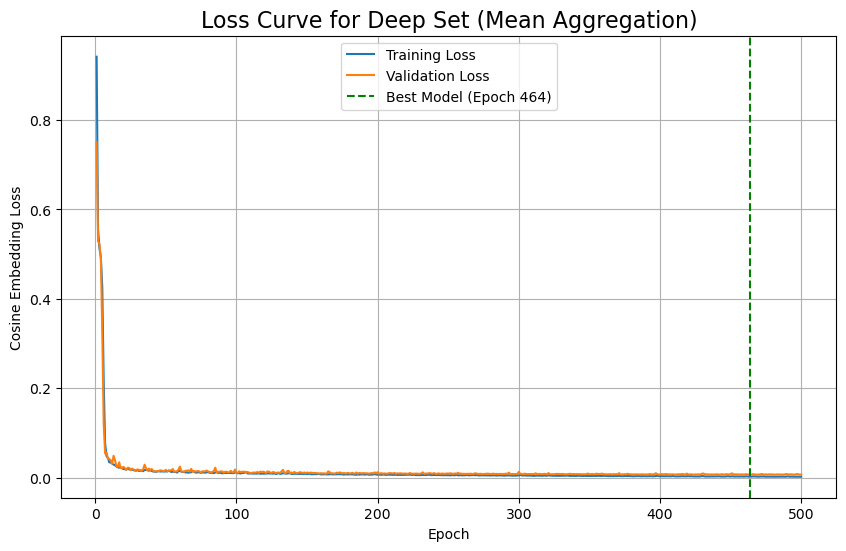


--- 7: Evaluating Best 'mean' Model on Test Set ---


Evaluating (mean): 100%|██████████| 16/16 [00:00<00:00, 30.05it/s]


Saved error vs events plot to 'error_vs_events_mean.png'


============================== FINAL RESULTS SUMMARY ==============================

--- Model Performance on Test Set ---
Model                     Mean Angular Error        Median Angular Error     
---------------------------------------------------------------------------
Deep Sets (Sum)           4.5652 degrees            3.0119 degrees           
Deep Sets (Max)           9.3071 degrees            7.6379 degrees           
Deep Sets (Mean)          4.7643 degrees            3.4154 degrees           
LMMLEM (Baseline)         6.6815                    degrees 0.7193                    degrees

--- Detailed Sample Predictions (l, b in degrees) ---

----------- Sample 1 -----------
  - Ground Truth        : ( 127.16,  21.47)
  - LMMLEM Pred         : ( 127.50,  22.50) -> Error: 1.08°
  - Deep Sets (Sum)     : ( 125.66,  25.50) -> Error: 4.26°
  - Deep Sets (Max)     : ( 131.26,  29.00) -> Error: 8.39°
  - Deep Sets (Mean)   

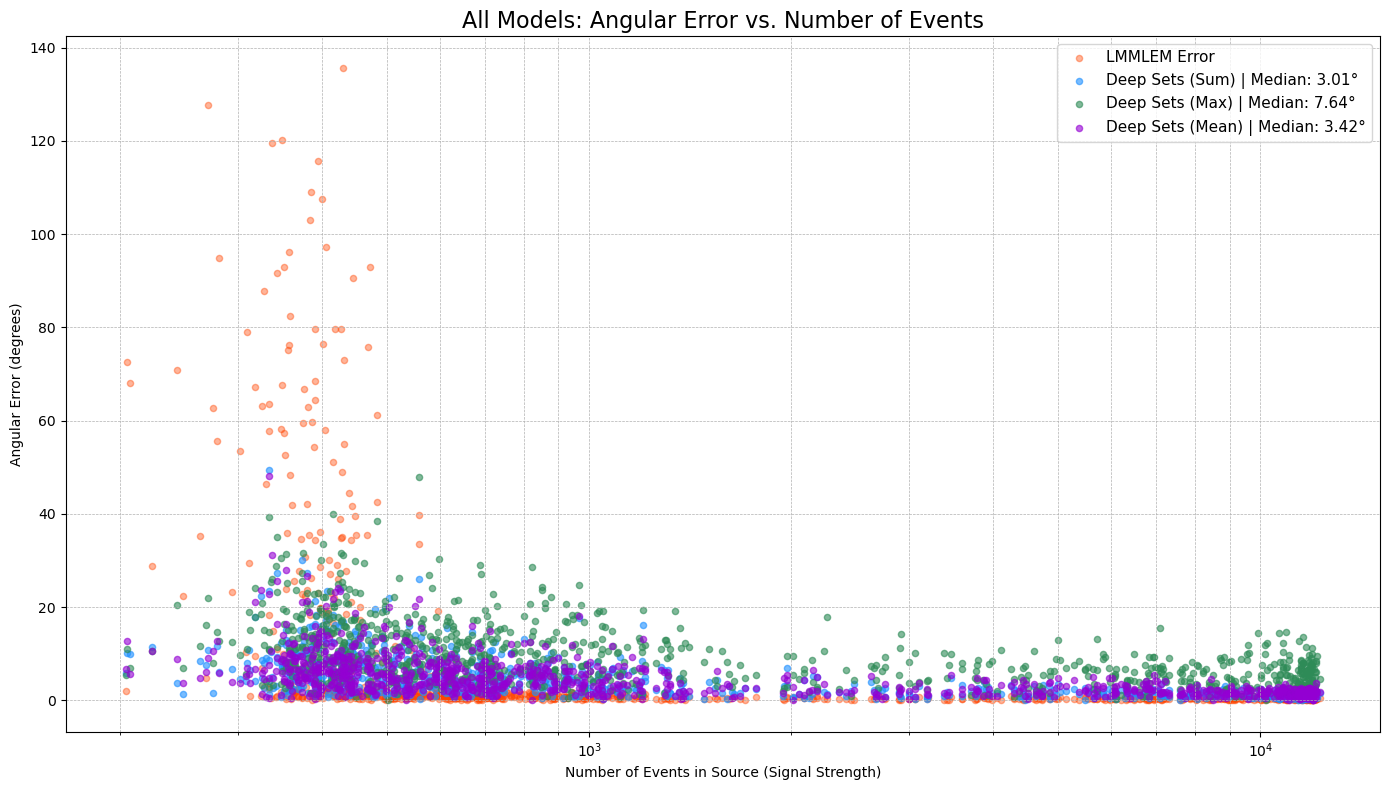

In [5]:
# ===================================================================
#                        4. MAIN SCRIPT
# ===================================================================

if __name__ == '__main__':
    # --- Configuration ---
    ANGULAR_FEATURE_INDICES = [1, 3, 4] 
    PHI_HIDDEN_DIMS = [128, 256, 512]
    LATENT_DIM = 1024
    RHO_HIDDEN_DIMS = [512, 256, 128, 64]
    LEARNING_RATE = 1e-4
    BATCH_SIZE = 64
    EPOCHS = 500
    DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"
    AGGREGATION_TYPES = ['sum', 'max', 'mean']

    # --- 1. Load and Preprocess Data ---
    print("--- 1: Loading and Preprocessing Data ---")
    x_events_raw = np.load("./All_Events_SignalBkg5_Deg.npy", allow_pickle=True)
    y_coords = np.load("./Ground_Truths.npy", allow_pickle=True)
    y_lon_lat_deg_true = np.array(y_coords[:, 1:3], dtype=np.float32)
    y_lon_lat_deg_lmmlem = np.array(y_coords[:, 3:5], dtype=np.float32)
    
    x_events_transformed = transform_event_features(x_events_raw, ANGULAR_FEATURE_INDICES)
    y_cartesian_true = convert_to_cartesian(y_lon_lat_deg_true)
    
    # --- 2. Create Splits and Fit Scaler ---
    print("\n--- 2: Creating Data Splits and Scaler ---")
    x_raw_train_val, x_raw_test, x_train_val, x_test, y_train_val, y_test, y_train_val_lb, y_test_lb, y_lmmlem_train_val, y_lmmlem_test = train_test_split(
        x_events_raw, x_events_transformed, y_cartesian_true, y_lon_lat_deg_true, y_lon_lat_deg_lmmlem,
        test_size=0.2, random_state=42)
    x_raw_train, x_raw_val, x_train, x_val, y_train, y_val, y_train_lb, y_val_lb, y_lmmlem_train, y_lmmlem_val = train_test_split(
        x_raw_train_val, x_train_val, y_train_val, y_train_val_lb, y_lmmlem_train_val,
        test_size=0.2, random_state=42)
    
    all_train_events = np.concatenate([events for events in x_train if events.shape[0] > 0])
    scaler = StandardScaler()
    scaler.fit(all_train_events)
    
    # --- 3. Create Datasets and DataLoaders ---
    print("\n--- 3: Setting up Datasets and DataLoaders ---")
    train_dataset = ComptonDataset(x_train, y_train, scaler)
    val_dataset = ComptonDataset(x_val, y_val, scaler)
    test_dataset = ComptonDataset(x_test, y_test, scaler)
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

    all_results = {}

    for agg_type in AGGREGATION_TYPES:
        print(f"\n\n{'='*25} TRAINING MODEL WITH '{agg_type.upper()}' AGGREGATION {'='*25}")

        # --- 4. Initialize Model ---
        print(f"\n--- 4: Initializing Model ({agg_type}) and Training Components ---")
        input_dim = all_train_events.shape[1]
        model = DeepSet(input_dim=input_dim, phi_hidden_dims=PHI_HIDDEN_DIMS, latent_dim=LATENT_DIM, rho_hidden_dims=RHO_HIDDEN_DIMS, agg_type=agg_type).to(DEVICE)
        criterion = nn.CosineEmbeddingLoss()
        optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
        print(f"Using device: {DEVICE}")
        
        # --- 5. Training Loop with Validation ---
        print("\n--- 5: Starting Training with Validation ---")
        train_losses, val_losses = [], []
        best_val_loss, best_epoch, best_model_state_dict = float('inf'), -1, None
        
        for epoch in range(EPOCHS):
            # --- Training Phase ---
            model.train()
            running_train_loss = 0.0
            # Use leave=False for a cleaner output
            for events_list, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]", leave=False):
                events_list, targets = [e.to(DEVICE) for e in events_list], targets.to(DEVICE)
                optimizer.zero_grad()
                outputs = model(events_list)
                loss = criterion(outputs, targets, torch.ones(outputs.shape[0]).to(DEVICE))
                loss.backward()
                optimizer.step()
                running_train_loss += loss.item()
            epoch_train_loss = running_train_loss / len(train_loader)
            train_losses.append(epoch_train_loss)
            
            # --- Validation Phase ---
            model.eval()
            running_val_loss = 0.0
            with torch.no_grad():
                # Use leave=False for a cleaner output
                for events_list, targets in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]  ", leave=False):
                    events_list, targets = [e.to(DEVICE) for e in events_list], targets.to(DEVICE)
                    outputs = model(events_list)
                    loss = criterion(outputs, targets, torch.ones(outputs.shape[0]).to(DEVICE))
                    running_val_loss += loss.item()
            epoch_val_loss = running_val_loss / len(val_loader)
            val_losses.append(epoch_val_loss)

            # --- Print Epoch Results on a Single Line ---
            print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {epoch_train_loss:.6f} | Val Loss: {epoch_val_loss:.6f}")

            # --- Check for Best Model ---
            if epoch_val_loss < best_val_loss:
                best_val_loss, best_epoch, best_model_state_dict = epoch_val_loss, epoch + 1, copy.deepcopy(model.state_dict())
        
        print(f"\n--- Training Complete for '{agg_type}' model. Best epoch: {best_epoch} (Val Loss: {best_val_loss:.6f}) ---")

        # --- 6. Plot Loss Curves Directly ---
        print(f"\n--- 6: Displaying Loss Curve Plot for '{agg_type}' model ---")
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, EPOCHS + 1), train_losses, label='Training Loss')
        plt.plot(range(1, EPOCHS + 1), val_losses, label='Validation Loss')
        plt.axvline(x=best_epoch, linestyle='--', color='green', label=f'Best Model (Epoch {best_epoch})')
        plt.title(f'Loss Curve for Deep Set ({agg_type.capitalize()} Aggregation)', fontsize=16)
        plt.xlabel('Epoch'), plt.ylabel('Cosine Embedding Loss'), plt.legend(), plt.grid(True)
        plt.show() # This will display the plot and pause execution until it's closed

        # --- 7. Evaluation on Test Set ---
        print(f"\n--- 7: Evaluating Best '{agg_type}' Model on Test Set ---")
        if best_model_state_dict: model.load_state_dict(best_model_state_dict)
        model.eval()
        all_preds_cart, all_targets_cart = [], []
        with torch.no_grad():
            for events_list, targets in tqdm(test_loader, desc=f"Evaluating ({agg_type})"):
                events_list = [e.to(DEVICE) for e in events_list]
                all_preds_cart.append(model(events_list).cpu().numpy())
                all_targets_cart.append(targets.cpu().numpy())
        y_pred_cart_deepset = np.concatenate(all_preds_cart)
        y_true_cart_eval = np.concatenate(all_targets_cart)
        angular_errors_deepset = calculate_angular_error(y_true_cart_eval, y_pred_cart_deepset)

        all_results[agg_type] = {
            'predictions_cart': y_pred_cart_deepset,
            'errors': angular_errors_deepset,
            'mean_error': np.mean(angular_errors_deepset),
            'median_error': np.median(angular_errors_deepset)
        }
        
        # --- 8. Error vs Events Plot (Saved for later) ---
        test_event_counts = [len(events) for events in x_raw_test]
        y_pred_cart_lmmlem = convert_to_cartesian(y_lmmlem_test)
        angular_errors_lmmlem = calculate_angular_error(y_true_cart_eval, y_pred_cart_lmmlem)
        plt.figure(figsize=(12, 7))
        plt.scatter(test_event_counts, angular_errors_lmmlem, alpha=0.5, s=20, label='LMMLEM Error', c='orangered')
        plt.scatter(test_event_counts, angular_errors_deepset, alpha=0.5, s=20, label=f'Deep Sets ({agg_type.capitalize()}) Error', c='dodgerblue')
        plt.title(f'Model Error vs. Events ({agg_type.capitalize()} Aggregation)', fontsize=16)
        plt.xlabel('Number of Events'), plt.ylabel('Angular Error (degrees)'), plt.xscale('log'), plt.legend(), plt.grid(True, which='both', linestyle='--')
        plt.savefig(f"error_vs_events_{agg_type}_500.png")
        plt.close() # Close figure to avoid displaying it now
        print(f"Saved error vs events plot to 'error_vs_events_{agg_type}.png'")


    # ===================================================================
    #              9. FINAL SUMMARY AND COMPARISONS
    # ===================================================================
    print("\n\n" + "="*30 + " FINAL RESULTS SUMMARY " + "="*30)
    
    # --- Print Summary Table ---
    print("\n--- Model Performance on Test Set ---")
    print(f"{'Model':<25} {'Mean Angular Error':<25} {'Median Angular Error':<25}")
    print("-" * 75)
    for agg_type, results in all_results.items():
        model_name = f"Deep Sets ({agg_type.capitalize()})"
        mean_err = f"{results['mean_error']:.4f} degrees"
        median_err = f"{results['median_error']:.4f} degrees"
        print(f"{model_name:<25} {mean_err:<25} {median_err:<25}")
    mean_err_lmmlem, median_err_lmmlem = np.mean(angular_errors_lmmlem), np.median(angular_errors_lmmlem)
    print(f"{'LMMLEM (Baseline)':<25} {mean_err_lmmlem:<25.4f} degrees {median_err_lmmlem:<25.4f} degrees")
    print("=" * 78)

    # --- Print Detailed Sample Predictions ---
    print("\n--- Detailed Sample Predictions (l, b in degrees) ---")
    predictions_lb_all_models = {
        agg: convert_cartesian_to_lon_lat(res['predictions_cart']) for agg, res in all_results.items()
    }
    num_samples_to_show = min(5, len(y_test_lb))
    for i in range(num_samples_to_show):
        print(f"\n----------- Sample {i+1} -----------")
        true_l, true_b = y_test_lb[i]
        print(f"  - {'Ground Truth':<20}: ({true_l:7.2f}, {true_b:6.2f})")
        
        lmmlem_l, lmmlem_b = y_lmmlem_test[i]
        lmmlem_err = angular_errors_lmmlem[i]
        print(f"  - {'LMMLEM Pred':<20}: ({lmmlem_l:7.2f}, {lmmlem_b:6.2f}) -> Error: {lmmlem_err:.2f}°")
        
        for agg_type in AGGREGATION_TYPES:
            deepset_l, deepset_b = predictions_lb_all_models[agg_type][i]
            deepset_err = all_results[agg_type]['errors'][i]
            model_name_str = f"Deep Sets ({agg_type.capitalize()})"
            print(f"  - {model_name_str:<20}: ({deepset_l:7.2f}, {deepset_b:6.2f}) -> Error: {deepset_err:.2f}°")

    # --- Create and Display Final Comparison Plot ---
    print("\n\n--- Generating Final Comparison Plot ---")
    plt.figure(figsize=(14, 8))
    colors = {'sum': 'dodgerblue', 'max': 'seagreen', 'mean': 'darkviolet'}
    plt.scatter(test_event_counts, angular_errors_lmmlem, alpha=0.4, s=20, label='LMMLEM Error', c='orangered')
    for agg_type, results in all_results.items():
        plt.scatter(test_event_counts, results['errors'], alpha=0.6, s=20, 
                    label=f"Deep Sets ({agg_type.capitalize()}) | Median: {results['median_error']:.2f}°", 
                    c=colors[agg_type])
    plt.title('All Models: Angular Error vs. Number of Events', fontsize=16)
    plt.xlabel('Number of Events in Source (Signal Strength)'), plt.ylabel('Angular Error (degrees)'), plt.xscale('log')
    plt.legend(fontsize=11), plt.grid(True, which='both', linestyle='--', linewidth=0.5), plt.tight_layout()
    plt.savefig("error_comparison_all_models_500.png")
    print("\nGenerated final comparison plot and saved as 'error_comparison_all_models.png'")
    plt.show()

In [6]:
all_train_events.shape

(10627698, 8)

In [7]:
print(min(angular_errors_lmmlem))
print(max(angular_errors_lmmlem))

0.0
135.65108


In [8]:
print(min(angular_errors_deepset))
print(max(angular_errors_deepset))

0.07401874
48.173477


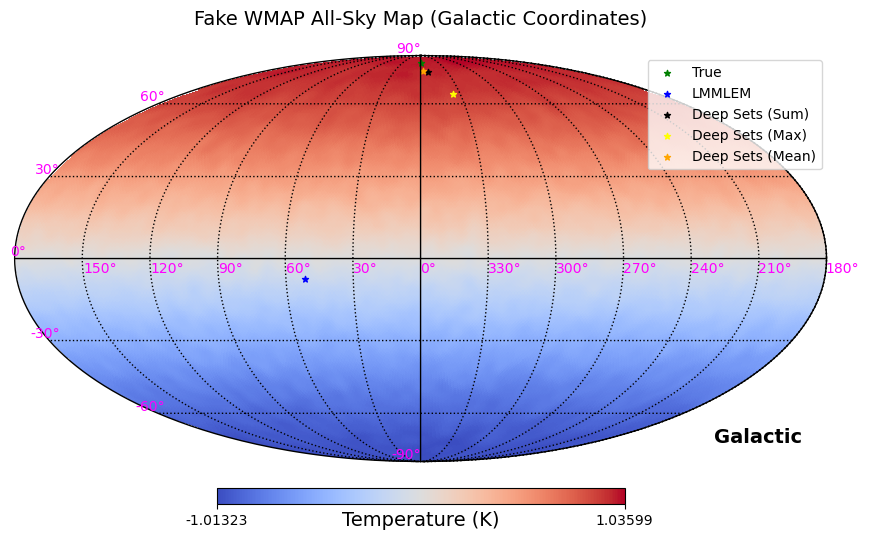

In [9]:
import healpy as hp
import matplotlib.pyplot as plt

# `healpy.visufunc` doesn't natively support graticule labels
# `healpy.newvisufunc` can plot graticule labels, but it's still an experimenting functionality (20241118), so it's better to use `healpy.visufunc` for now
# produce mock WMAP-like map
nside = 64  # Set to 64 for simplicity; higher values give finer resolution
npix = hp.nside2npix(nside)

# Create synthetic WMAP-like data
# Example: Use a sine gradient for Galactic latitude with random noise
l, b = hp.pix2ang(nside, np.arange(npix), lonlat=True)  # Longitude (l), Latitude (b)
data = np.sin(np.radians(b)) + 0.1 * np.random.randn(npix)  # Gradient + Noise

# Smooth the data to mimic WMAP features (optional)
data_smoothed = hp.smoothing(data, sigma=np.radians(2.0))  # 2-degree smoothing

# plot the healpy map
hp.mollview(data_smoothed, unit="Temperature (K)", cmap="coolwarm", coord = "G")
hp.graticule(coord = "G")

# The labels of graticule to plot
latitudes = np.arange(-90, 91, 30)  # Latitude labels in degrees
longitudes = np.arange(0, 359, 30)  # Longitude labels in degrees

# Loop through and place the labels on the plot
for lat in latitudes:
    hp.projtext(175, lat, f"{lat}°", lonlat=True, color="magenta", fontsize=10,
                horizontalalignment = "right", verticalalignment = "bottom")

for lon in longitudes:
    hp.projtext(lon, -5, f"{lon}°", lonlat=True, color="magenta", fontsize=10)

# hp.projscatter(
#     120, 30,
#     lonlat=True,
#     color="green",
#     s=120,
#     marker="*",
#     coord="G"
# )

# y_test_lb = [239.78, 34.987]

hp.projscatter(y_test_lb[1][0], y_test_lb[1][1],
               lonlat=True, color="green", s=20, marker="*", coord="G", label='True')

hp.projscatter(y_lmmlem_test[1][0], y_lmmlem_test[1][1],
               lonlat=True, color="blue", s=20, marker="*", coord="G", label='LMMLEM')

hp.projscatter(predictions_lb_all_models['sum'][1][0], predictions_lb_all_models['sum'][1][1],
               lonlat=True, color="black", s=20, marker="*", coord="G", label='Deep Sets (Sum)')

hp.projscatter(predictions_lb_all_models['max'][1][0], predictions_lb_all_models['max'][1][1],
               lonlat=True, color="yellow", s=20, marker="*", coord="G", label='Deep Sets (Max)')

hp.projscatter(predictions_lb_all_models['mean'][1][0], predictions_lb_all_models['mean'][1][1],
               lonlat=True, color="orange", s=20, marker="*", coord="G", label='Deep Sets (Mean)')

fig = plt.gcf()
ax = plt.gca()
plt.legend(loc="upper right", fontsize=10)  # choose loc as you like
# control the position of the titile, so it won't overlap the 90 deg latitude label
ax.set_title("Fake WMAP All-Sky Map (Galactic Coordinates)", fontsize=14, y=1.05)
# Save the figure
plt.savefig("wmap_sample_map_500.png", dpi=300, bbox_inches="tight")

# Optional: Show the figure
plt.show()
